# Deep Recurrent Learning (N-BEATS) vs. Traditional Machine Learning
## Advanced Machine Learning in Finance - Individual Project

The aim of this project is to compare the performance of two machine learning models, N-Beats and XGBoost, for predicting sales figures. The challenge is to use available data that has a correlation with the sales of various companies, such as credit card transactions to predict the quarterly sales figures.

The goal is to compare the accuracy of predictions for the current quarter, as well as the next couple of quarters, between N-Beats and XGBoost.

N-Beats is a deep learning model designed specifically for time-series forecasting, while XGBoost is a popular tree-based model used for various types of predictive modeling. This project aim to give insights into comparative forecasting results from these two models and their applications in the field of sales prediction.

The outcome of this project will be a comparison between the two models, including a discussion of the results and their implications for businesses and organizations looking to improve their financial forecasting capabilities.

In [1]:
import darts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch 
import os
import sys
import sklearn 
import torch
from utils import DataFrameProcessor, ModelPipeline
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts import TimeSeries
import darts.metrics as metrics
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

# Data Extraction

In [2]:
processor = DataFrameProcessor('exabel_data')

In [3]:
# / TODO add covid data as it may be a strong covariate for the time series at question
processor.files

['revenue.xlsx', '.DS_Store', 'covid_us.csv', 'spend_amounts_aggregated.xlsx']

In [4]:
revenue = processor.create_df(processor.revenue)
spendings = processor.create_df(processor.spendings)
df = processor.merge_spendings_revenue(spendings, revenue)
df = processor.create_stationary_covariates(df)
df = processor.add_war_to_df(df)
df = processor.encode_index(df)
df = processor.remove_small_tickers(df)
df = processor.remove_missing_ground_truth(df)

## Data Exploration

In [5]:
# ALL THE COMPANIES IN THE DATA

# 'FLWS', 'AMC', 'T', 'ANF', 'ASO', 'ATVI', 'ADBE', 'AAP', 'AFRM',
# 'ABNB', 'ALK', 'ACI', 'ALGT', 'ALLY', 'GOOGL', 'ATUS', 'AMZN',
# 'AMXL', 'AAL', 'AEO', 'AEP', 'ANGI', 'AAPL', 'ARMK', 'AZO', 'CAR',
# 'BARK', 'BJRI', 'BJ', 'BP', 'BBWI', 'BBBY', 'BBY', 'BIG', 'SQ',
# 'BLMN', 'APRN', 'BKNG', 'BOOT', 'EAT', 'BBW', 'BMBL', 'BURL',
# 'CVS', 'CAL', 'CWH', 'CTLP', 'CPRI', 'KMX', 'CCL', 'CRI', 'CASY',
# 'FUN', 'CHTR', 'CAKE', 'CHGG', 'CVX', 'CHWY', 'CHS', 'CMG', 'CHH',
# 'CMPR', 'CNK', 'CTRN', 'COIN', 'CMCSA', 'CONN', 'COP', 'COST',
# 'CBRL', 'CROX', 'CUBE', 'DISH', 'DRI', 'PLAY', 'DECK', 'DAL',
# 'DENN', 'DBI', 'DXLG', 'DKS', 'DDS', 'DIN', 'DG', 'DLTR', 'DPZ',
# 'DASH', 'DKNG', 'DBX', 'DLTH', 'EA', 'EFX', 'EL', 'ETSY', 'EB',
# 'ES', 'EXPE', 'EXPN', 'EXPR', 'XOM', 'FDX', 'FIVE', 'FVRR', 'FLTR',
# 'FL', 'FTV', 'FRG', 'FTDR', 'ULCC', 'GME', 'GPS', 'GEN', 'GM',
# 'GCO', 'GPC', 'GDDY', 'GO', 'GRPN', 'HRB', 'HOG', 'HLF', 'HTZ',
# 'HIBB', 'HLT', 'HUM', 'H', 'IAC', 'INTU', 'JACK', 'JBLU', 'KSS',
# 'AD', 'DNUT', 'LL', 'MC', 'LE', 'LEVI', 'LYV', 'LOW', 'LYFT', 'M',
# 'MPC', 'MAR', 'MTCH', 'MAT', 'MCD', 'META', 'MSFT', 'MGI', 'MUSA',
# 'NKE', 'NAVI', 'NFLX', 'NWL', 'NDLS', 'JWN', 'NCLH', 'ORLY',
# 'OLLI', 'OMF', 'OSTK', 'OXM', 'PENN', 'PVH', 'PZZA', 'PRTYQ',
# 'PYPL', 'PTON', 'PETS', 'PSX', 'PLNT', 'PLTK', 'POSH', 'PBPB',
# 'PGR', 'DGX', 'QRTEA', 'RL', 'RRGB', 'RCII', 'RSG', 'QSR', 'RAD',
# 'RBLX', 'ROKU', 'ROL', 'ROST', 'RSI', 'SBH', 'SCHL', 'SEAS', 'S',
# 'SHAK', 'SHEL', 'SCVL', 'SHOP', 'SIG', 'SIRI', 'SIX', 'SKX',
# 'SKLZ', 'SNA', '6758', 'LUV', 'LOV', 'SAVE', 'SPOT', 'SFM', 'SBUX',
# 'SFIX', 'SUN', 'TMUS', 'TPR', 'TGT', 'TXRH', 'AAN', 'ALL', 'BKE',
# 'CATO', 'PLCE', 'TCS', 'HIG', 'HD', 'KR', 'NYT', 'ODP', 'SHW',
# 'TJX', 'TRV', 'DIS', 'WEN', 'TSCO', 'TA', 'TUP', 'UHAL', 'UBER',
# 'ULTA', 'UAA', 'UAL', 'UPS', 'USM', 'UNH', 'URBN', 'VFC', 'VVV',
# 'VRA', 'VZ', 'SEAT', 'VVNT', 'WW', 'WBA', 'WMT', 'WM', 'W', 'WSM',
# 'WING', 'WINA', 'WIX', 'WH', 'YETI', 'YUM', 'ZM', 'ZUMZ', 'EBAY',
# 'FUBO', 'IMBI', 'LULU'

In [6]:
# total number of companies
len(df['ticker'].unique())

218

#### Missing values

In [7]:
df.isna().sum()

mic                         0
ticker                      0
time                        0
nw_total_sales_a_total    154
nw_total_sales_b_total    680
Sales_Actual_fiscal        91
Sales_Estimate_fiscal     116
year                        0
month                       0
quarter                     0
is_war                      0
dtype: int64

#### Inspecting whether seasonality is justified with including data for companies with 10 rows of data (each row correspond to a fiscal quarter)

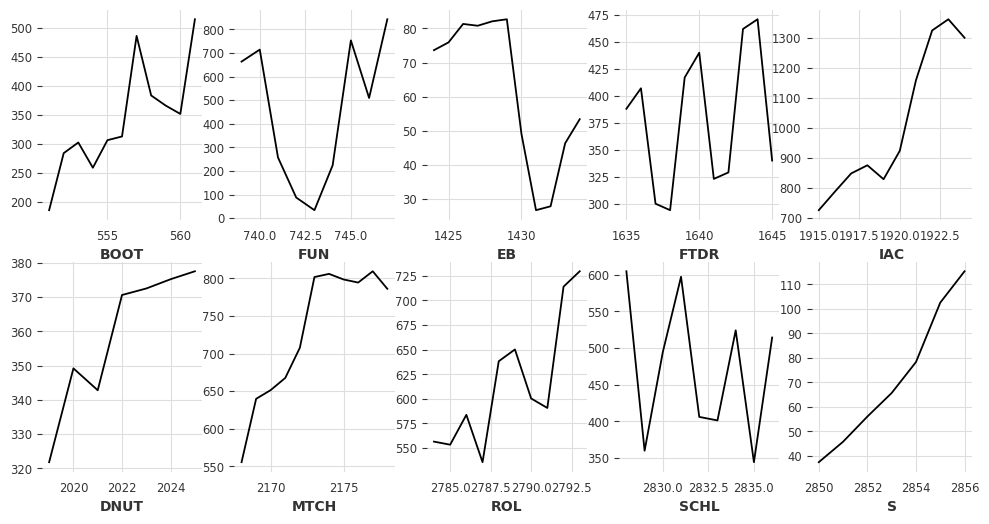

In [8]:
i, j = 0, 0
fig, ax = plt.subplots(2, 5, figsize=(12,6))

for tic in df['ticker'].unique():
    df_copy = df[df['ticker'] == tic]
    if df_copy.shape[0] < 12:
        ax[i][j].plot(df_copy['Sales_Actual_fiscal'])
        ax[i][j].set_xlabel(tic)
        j += 1
        if j == 5:
            j = 0
            i += 1
        if i == 2:
            break
        
plt.show()



In [9]:
def print_nans_index(df):
    """ 
    
    """
    for tic in np.unique(df.ticker):
        df_copy = df[df['ticker'] == tic]
        
        if df_copy.isnull().values.any():
            print('\n')
            print(f"Ticker: {tic}, # Data points: {df_copy.shape[0]}")
        df_copy = df_copy.reset_index(drop=False)
        
        for col in df_copy.columns:
            nan_count = df_copy[col].isnull().sum()
        
            if nan_count > 0:
                nan_indices = df_copy[df_copy[col].isnull()].index.tolist()
                nan_row_counts = [index + 1 for index in nan_indices]
                print(f"Column: {col}, NaN Indices: {nan_indices}")
        
print_nans_index(df)



Ticker: AAL, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AAP, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 3]


Ticker: AAPL, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: ABNB, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]
Column: Sales_Actual_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7]


Ticker: AD, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 3]


Ticker: ADBE, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEO, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEP, # Data points: 14
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


Ticker: ALL, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AMC, # Data points: 

We see that the vast majority of missing vals are happening in the column 'nw_total_sales_b_total' for the indices in some form of subset of [0,1,2,3] s0 that it makes sense to impute these values to avoid missing large amounts of data.

In [10]:
# Correlation Matrix
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

Based on the strong linear correlation between total sales between group A and B, it can make sense to find a linear model for when these are NaN based on the values for which they are not NaN and make mappings between them and impute values from those linear mappings. One could use ridge regression to find the more important features (or lasso for shrinkage). Both due to time constraints of the project and to its effect on computational efficicency this is ignored for this project. Other ideas could be to use KNNs or KD-Balls for instance when trying to impute these values. As the project is restricted to 10 pages, it would require too much space in the explanation to do so. Note that the linearity between the variables is an exploratory assumption even though correlation can indicate that the relationship can be non-linear (e.g., polynomial, exponential, etc.). 

# /TODO include plot for linear relationship between sales A and sales B

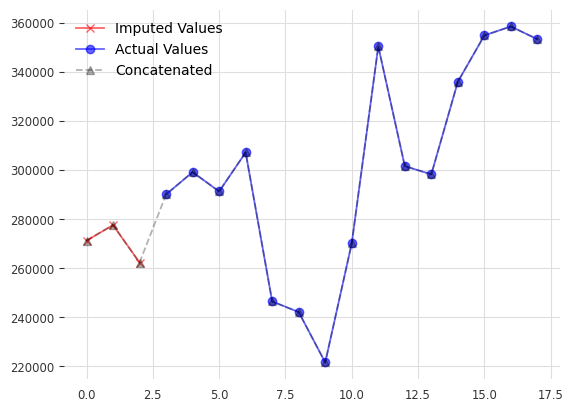

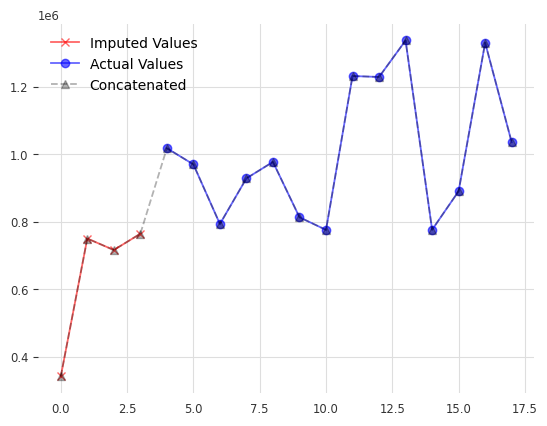

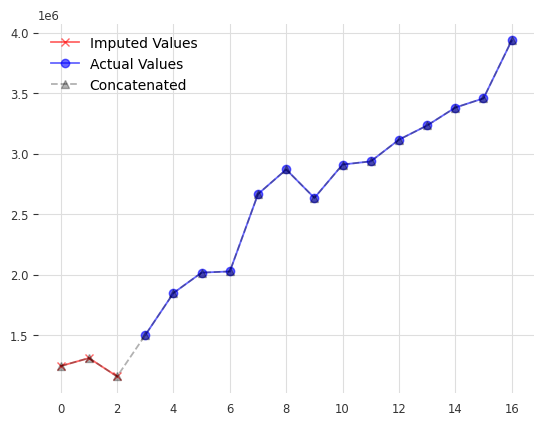

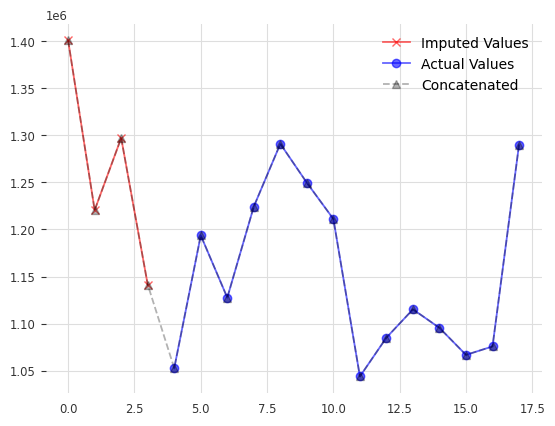

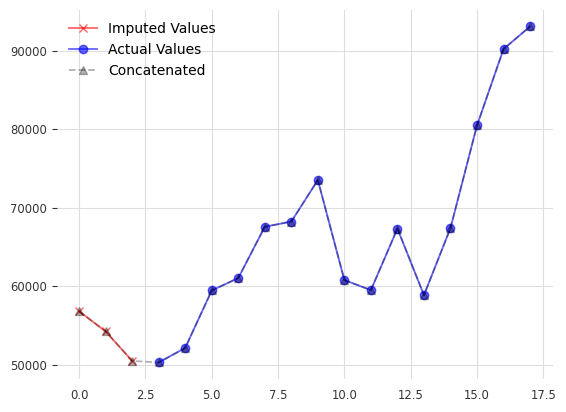

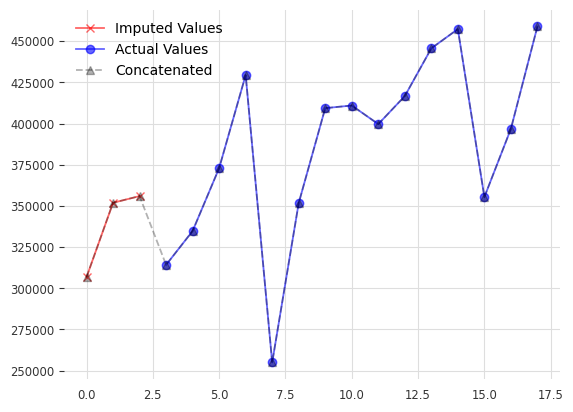

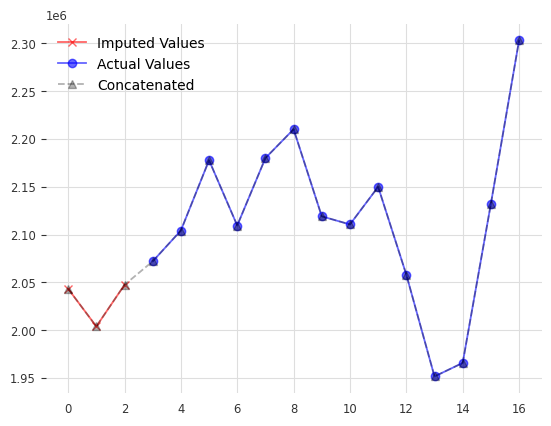

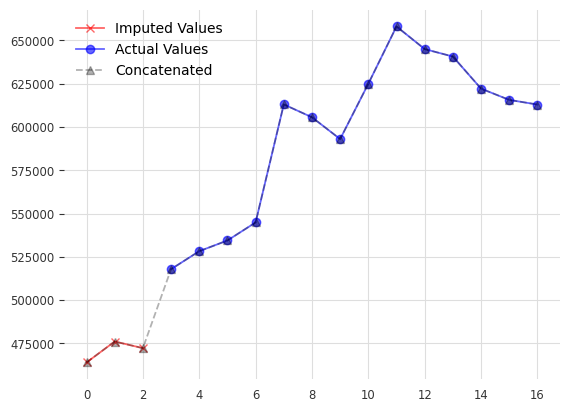

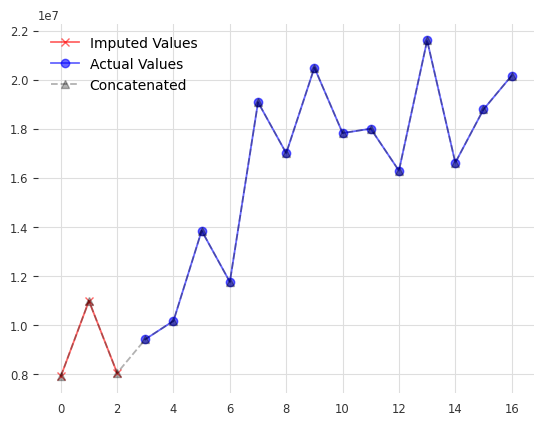

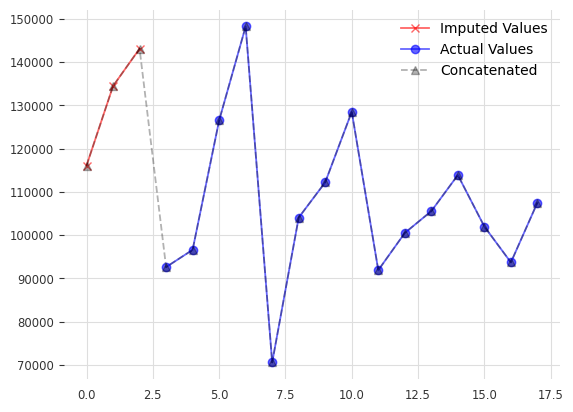

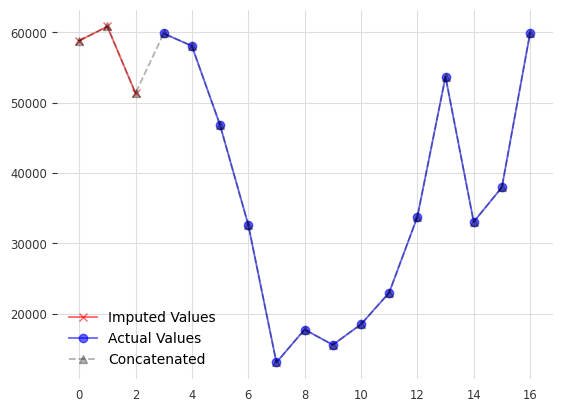

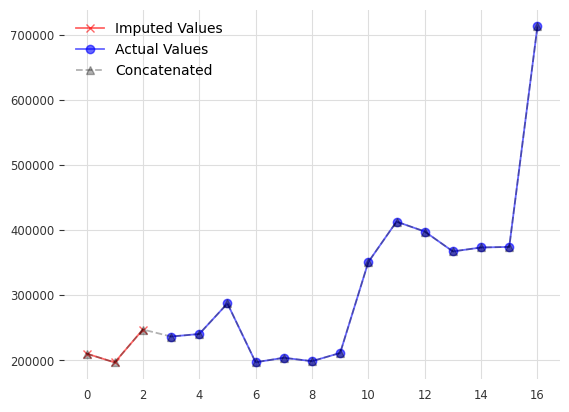

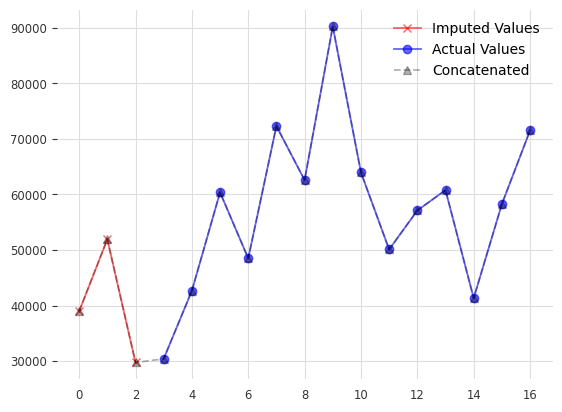

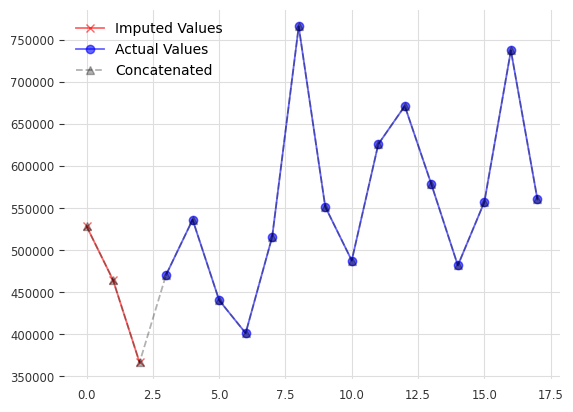

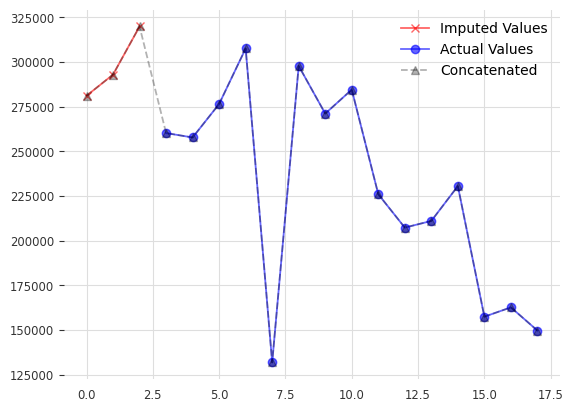

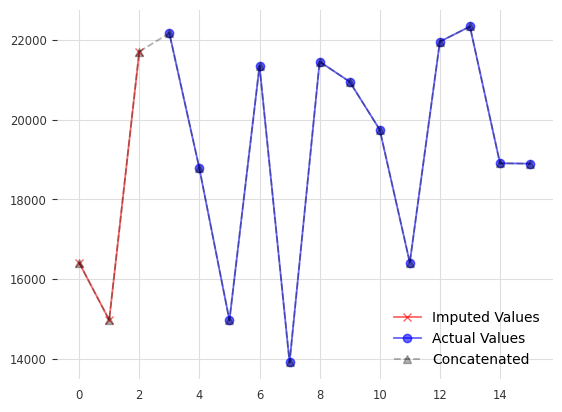

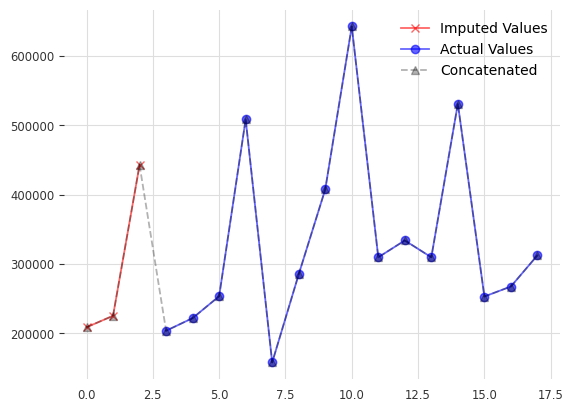

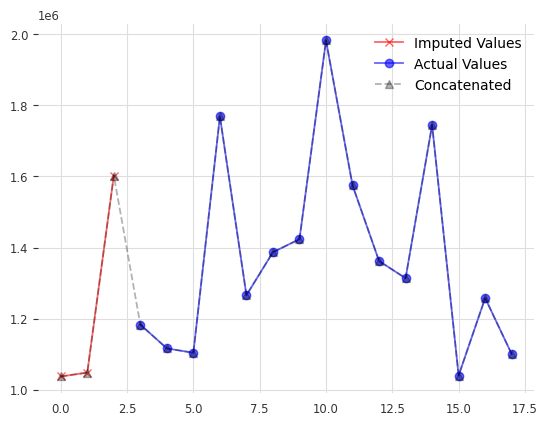

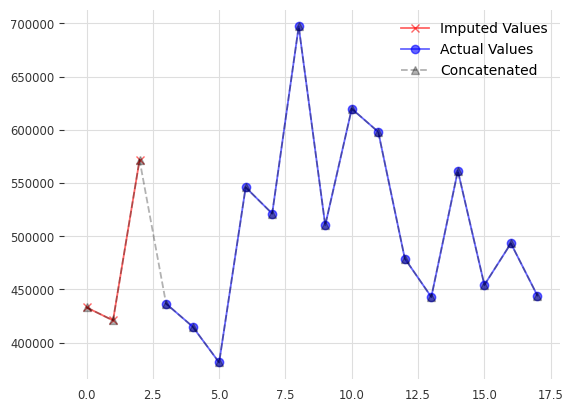

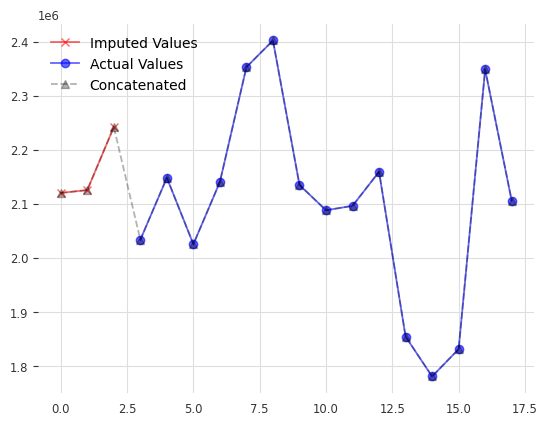

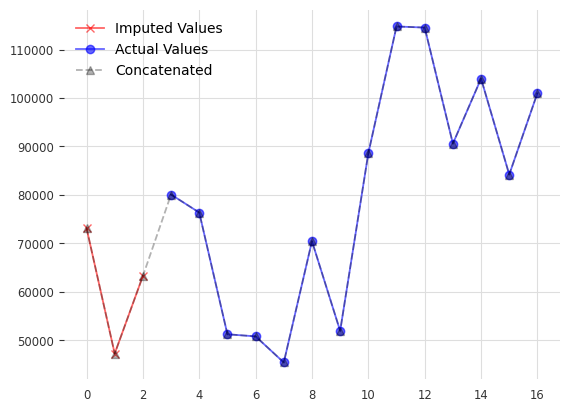

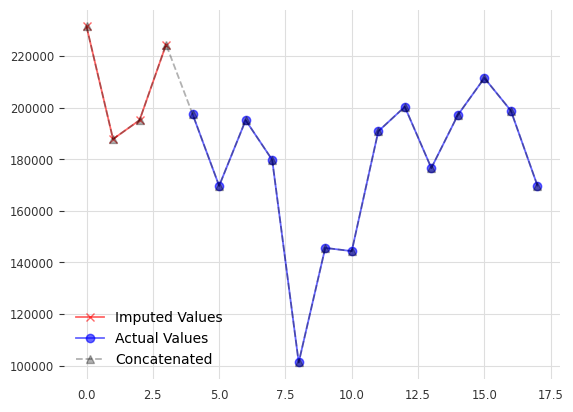

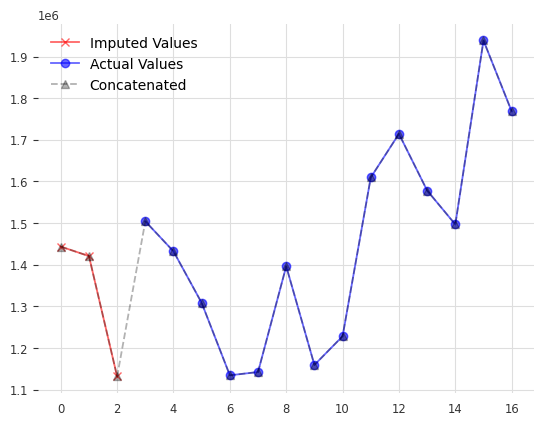

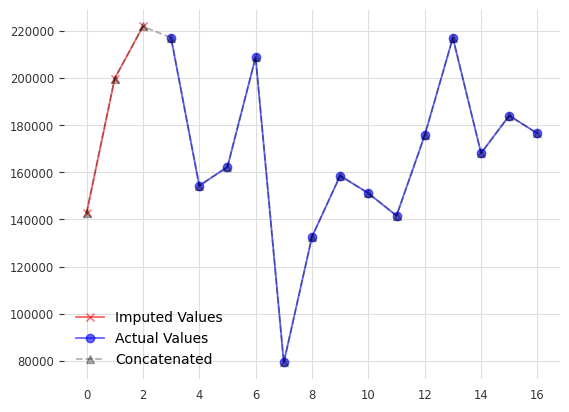

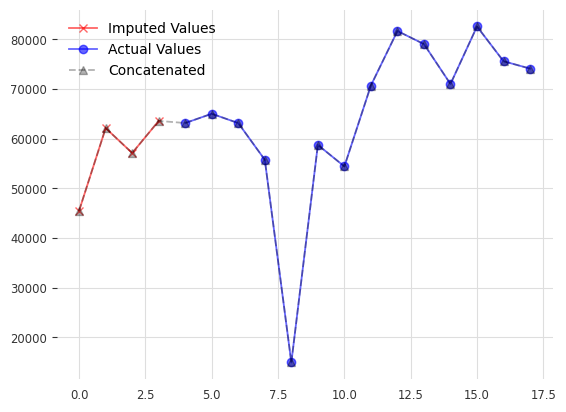

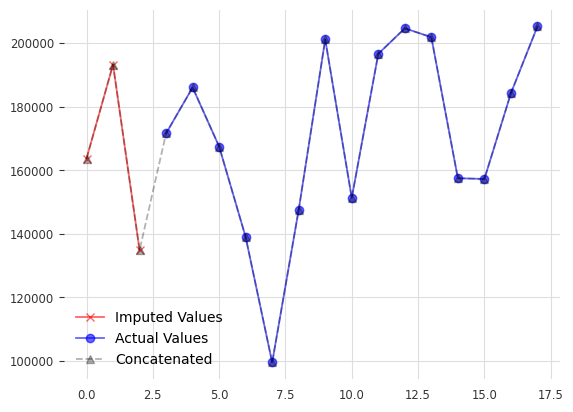

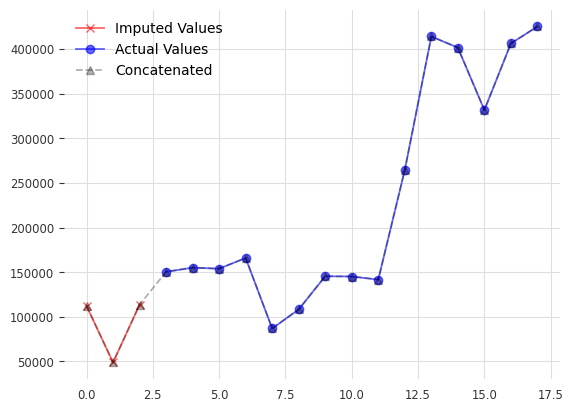

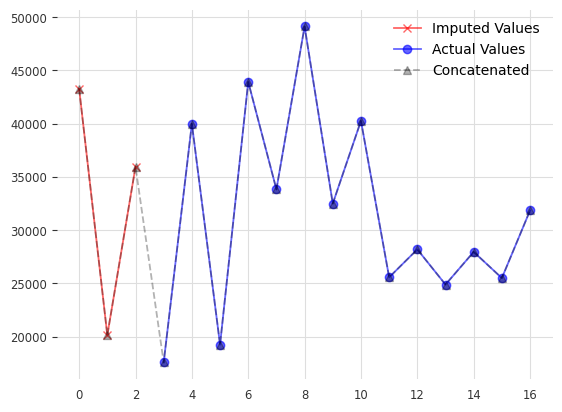

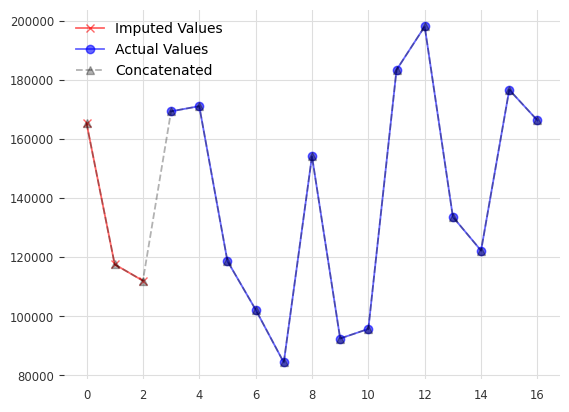

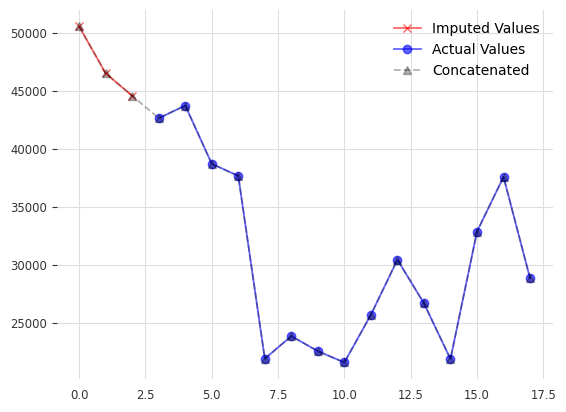

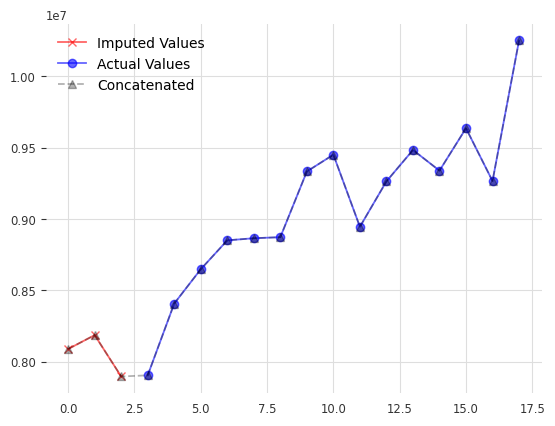

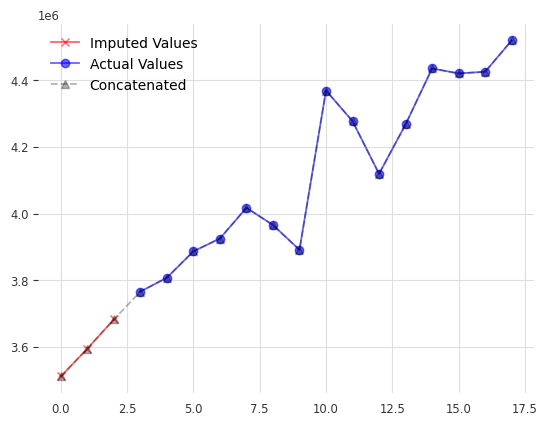

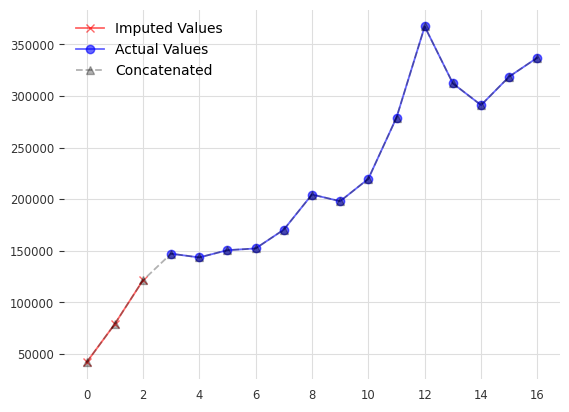

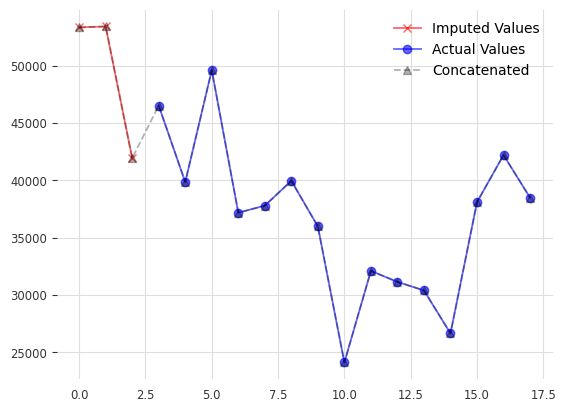

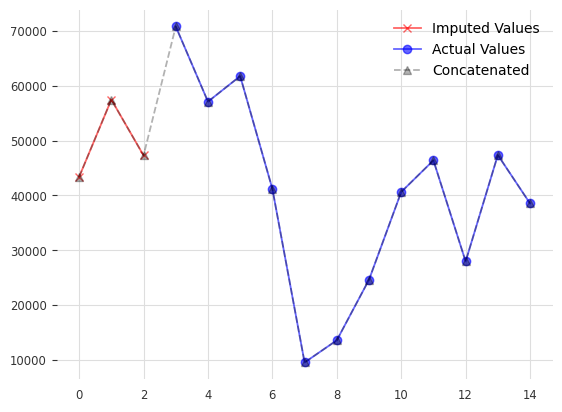

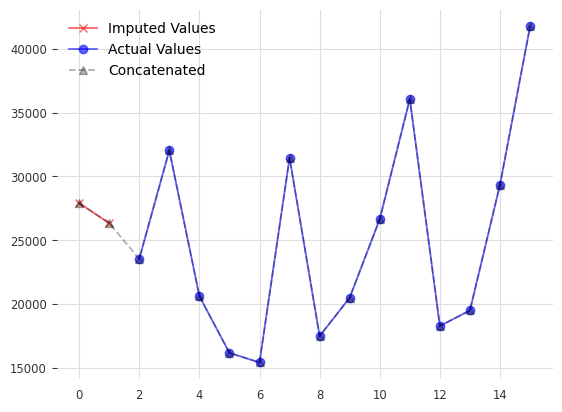

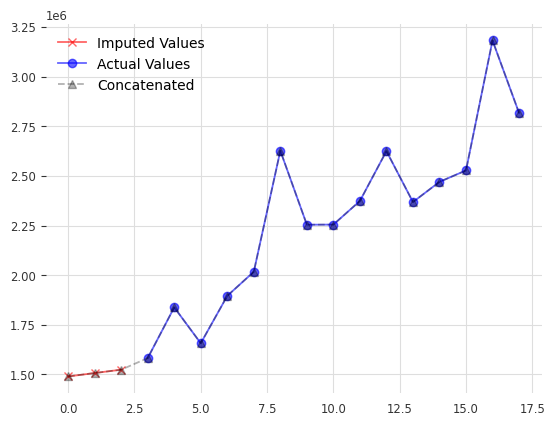

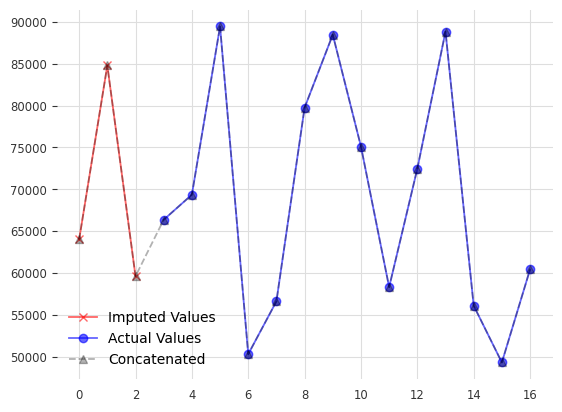

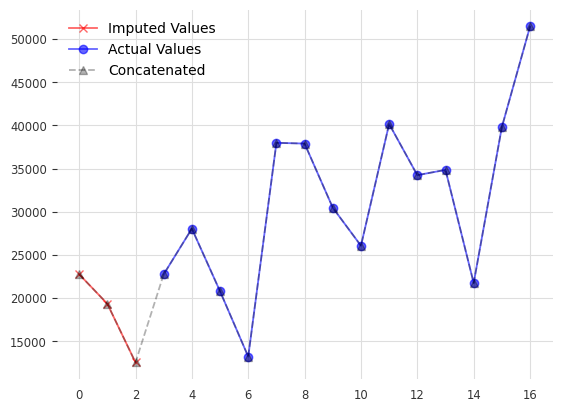

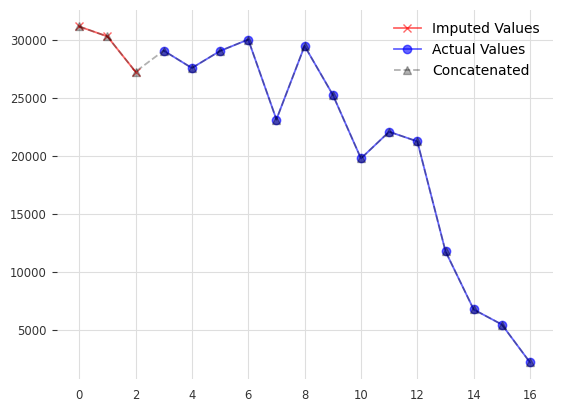

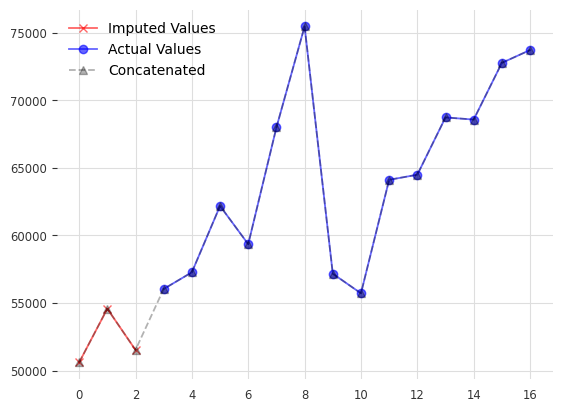

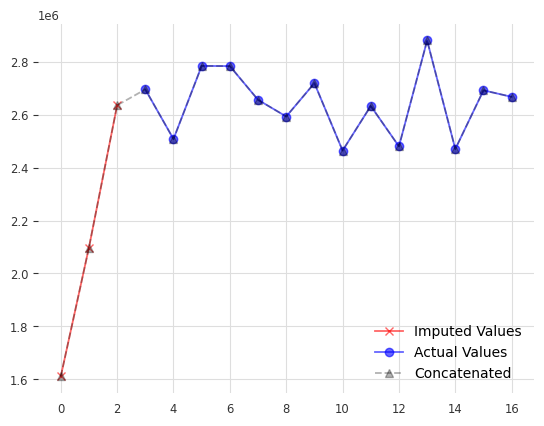

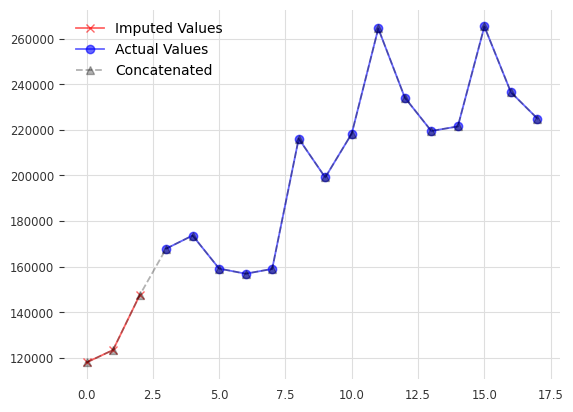

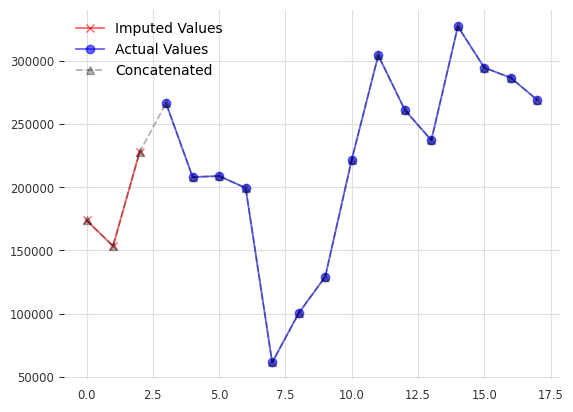

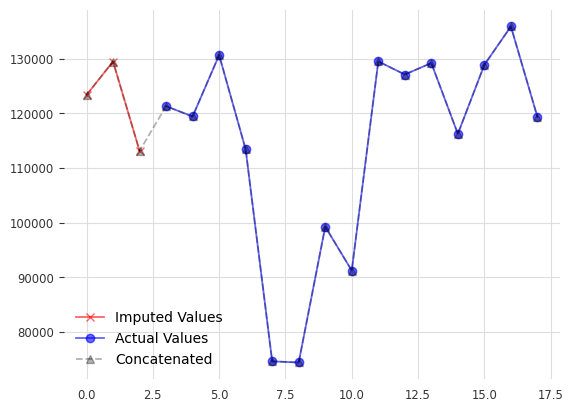

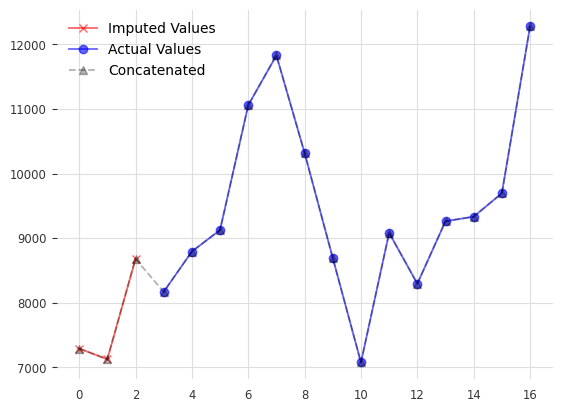

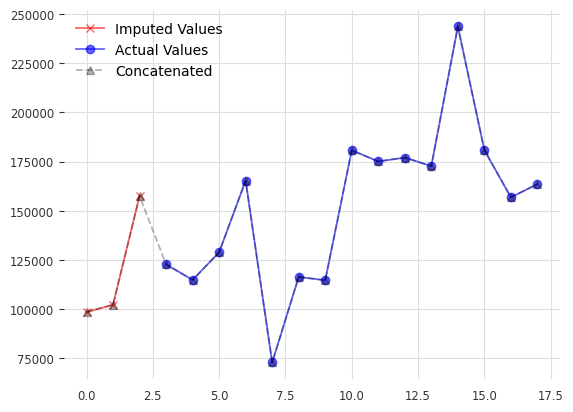

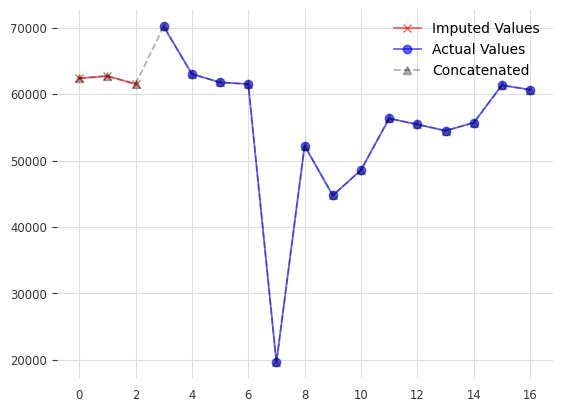

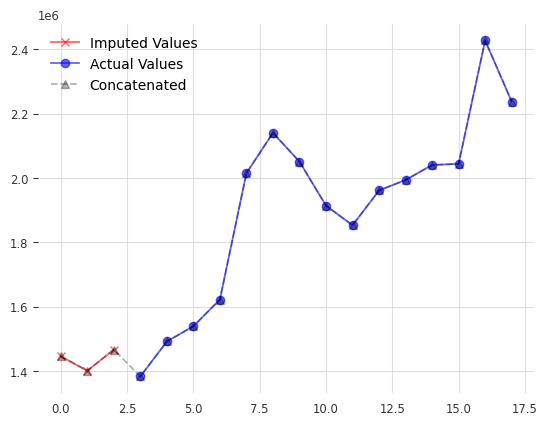

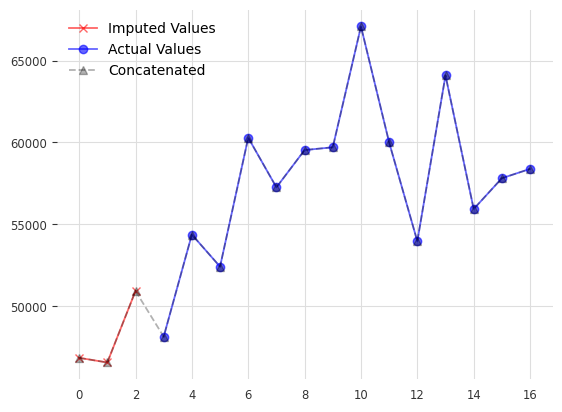

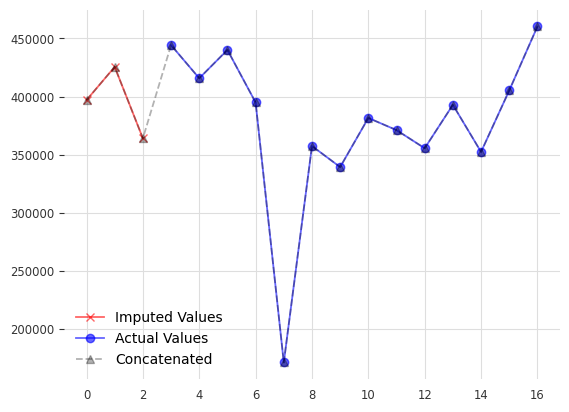

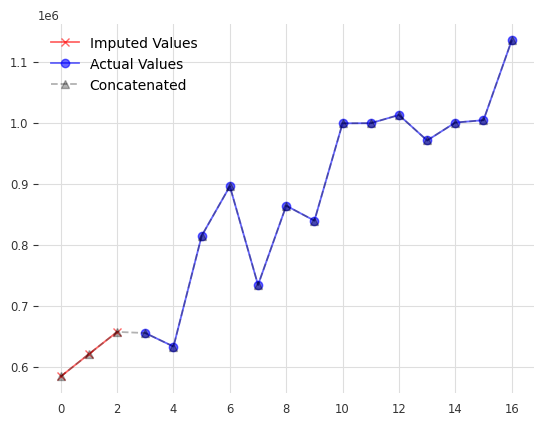

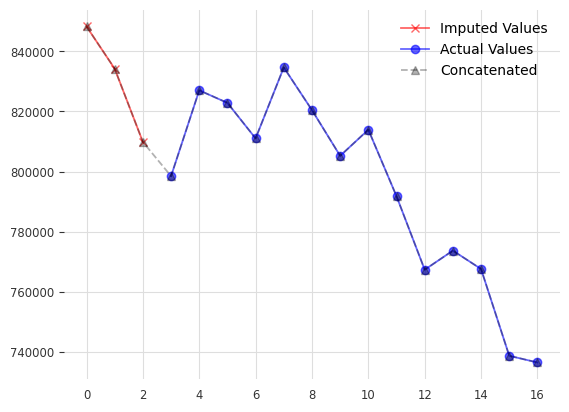

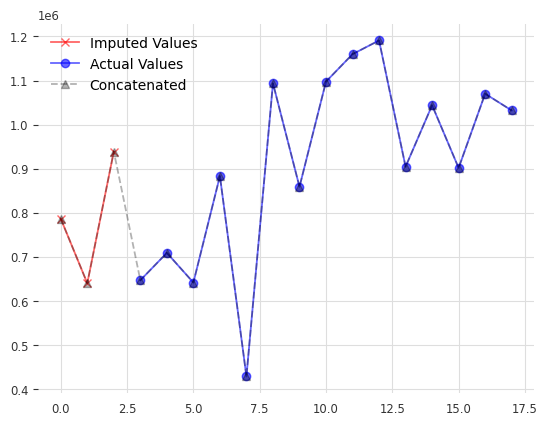

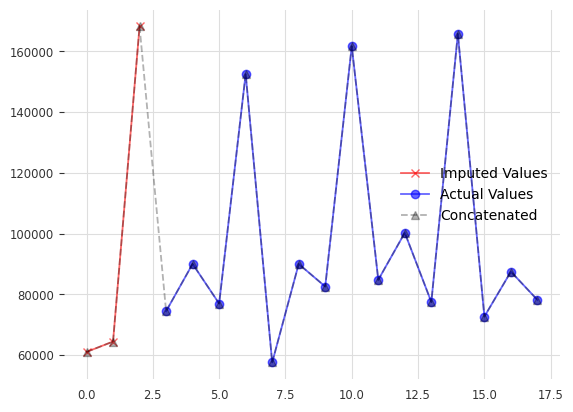

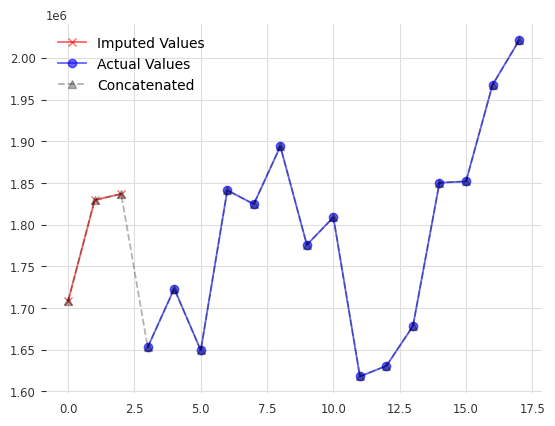

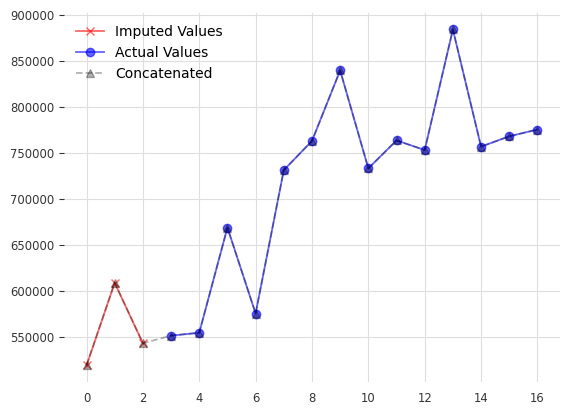

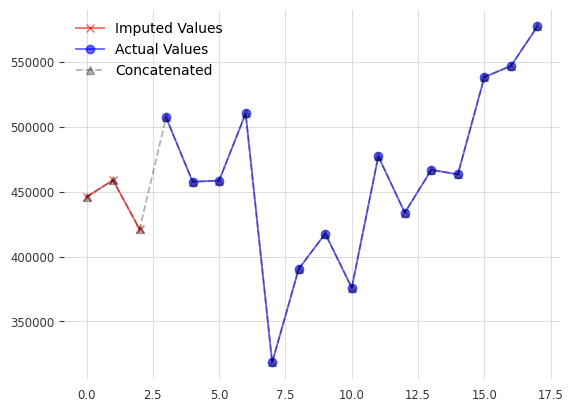

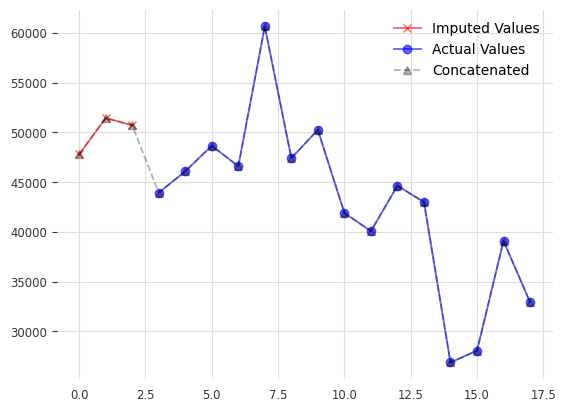

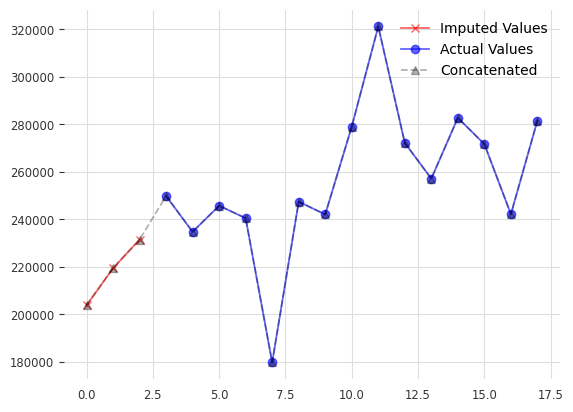

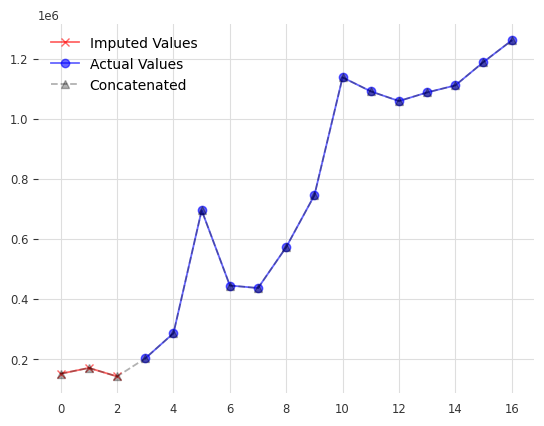

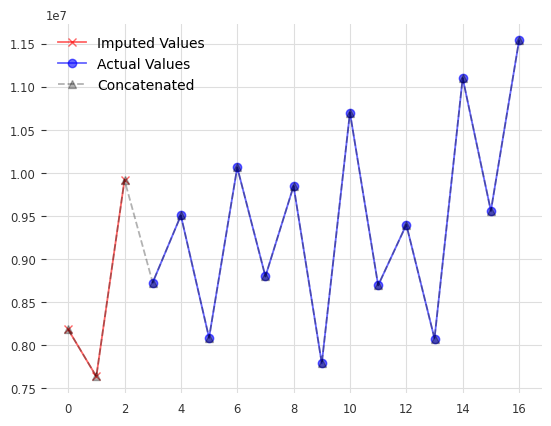

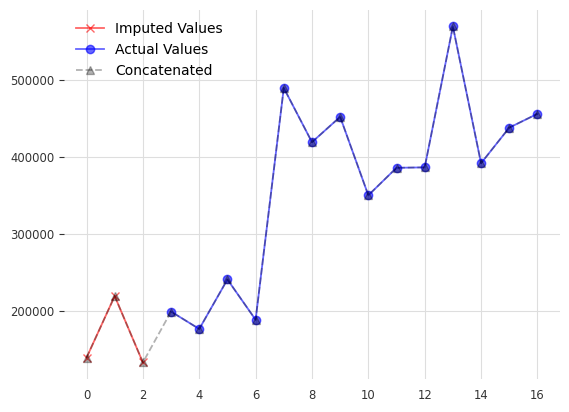

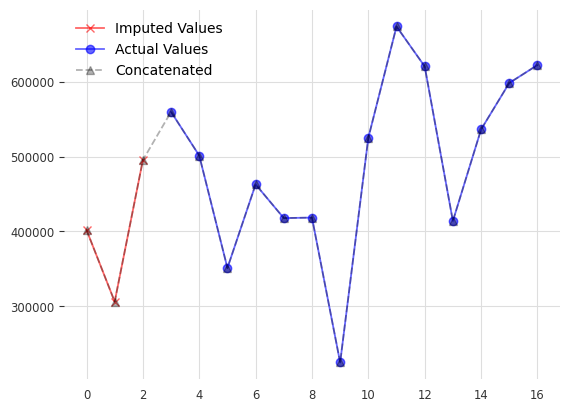

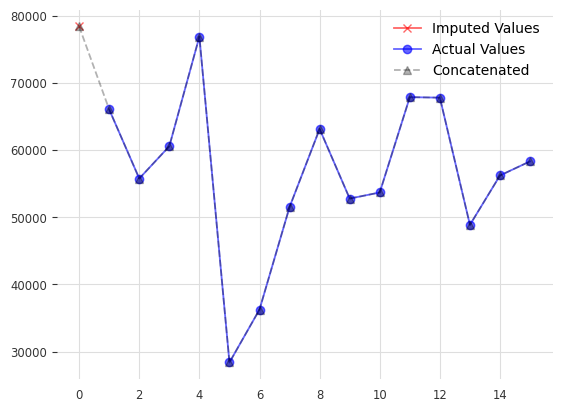

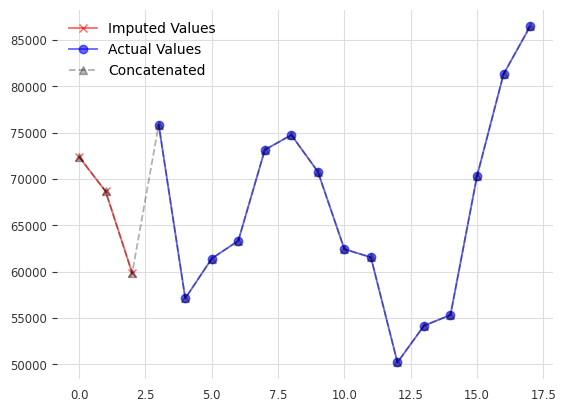

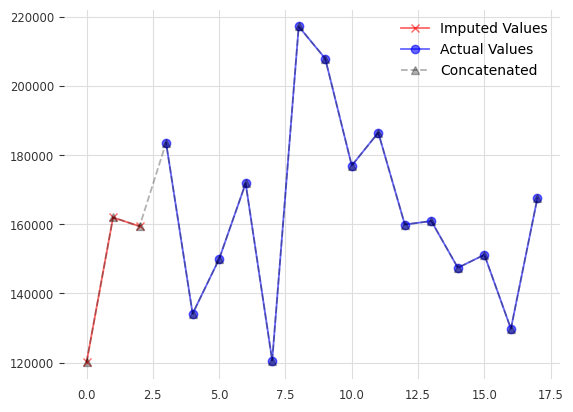

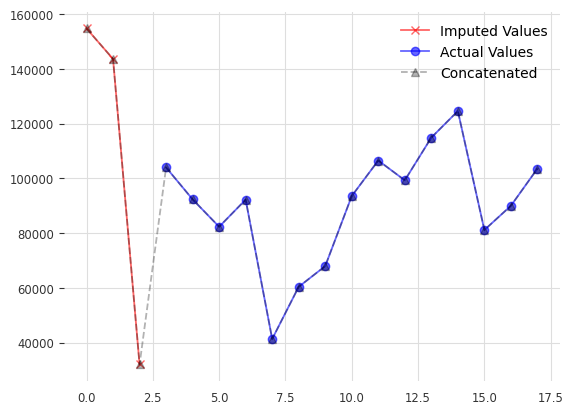

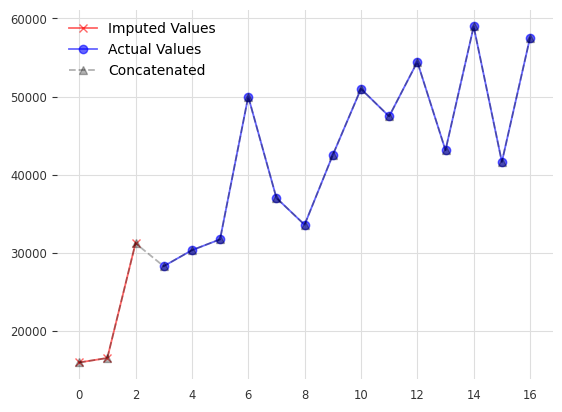

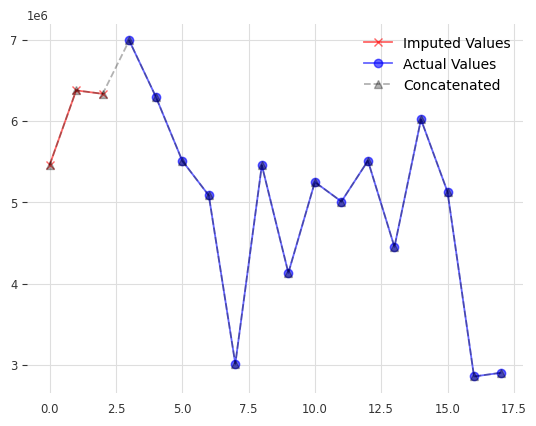

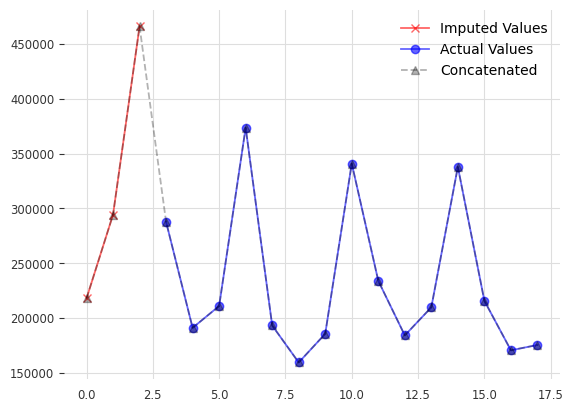

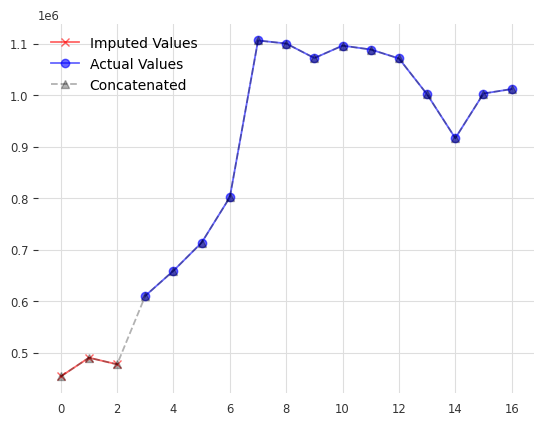

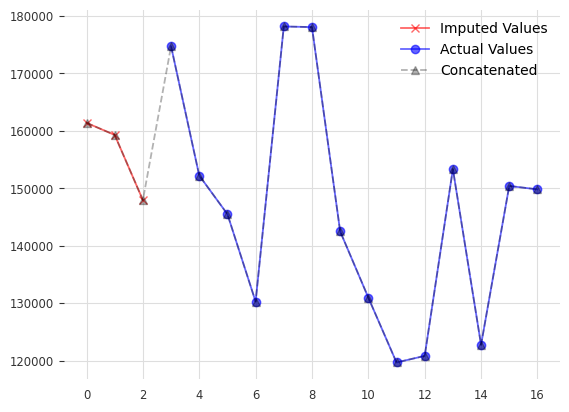

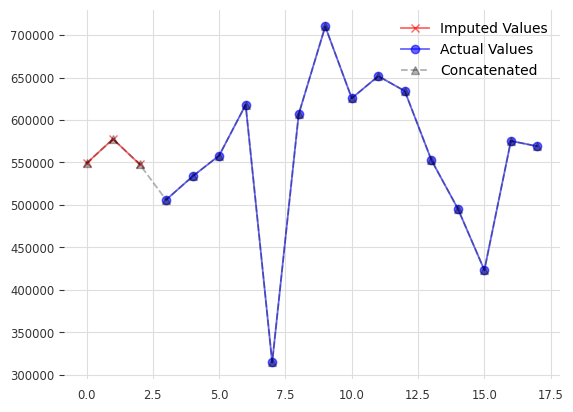

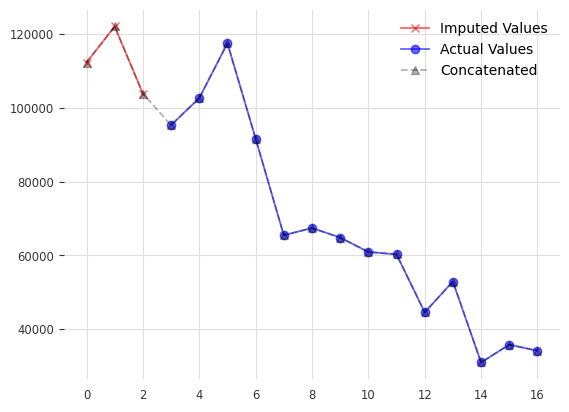

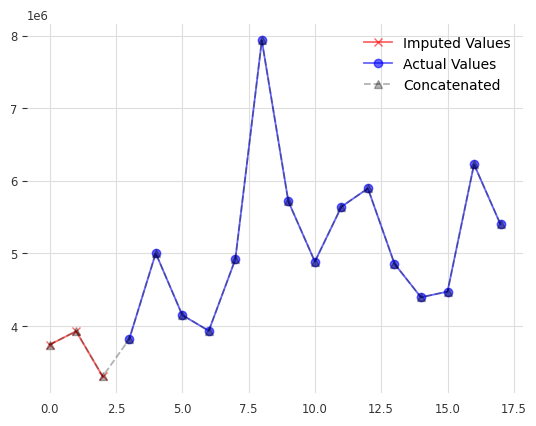

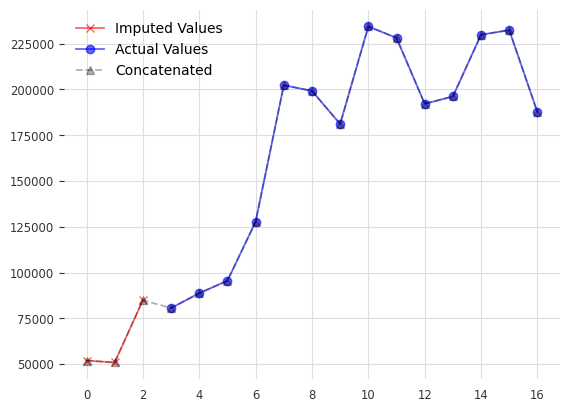

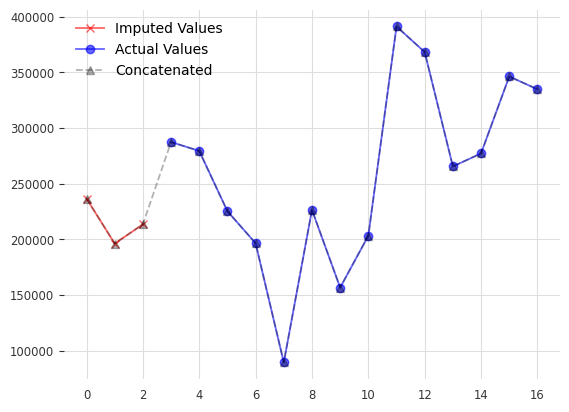

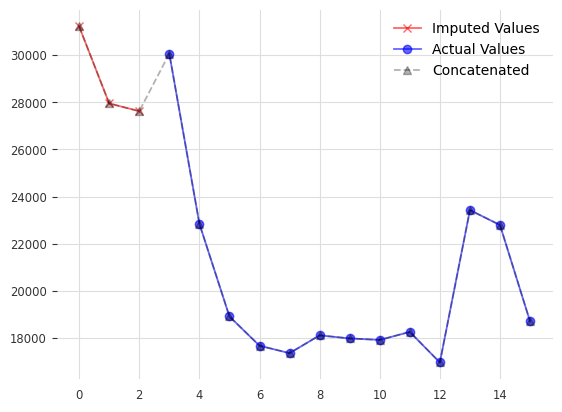

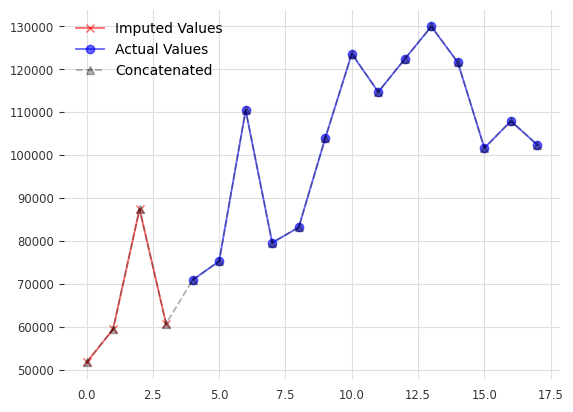

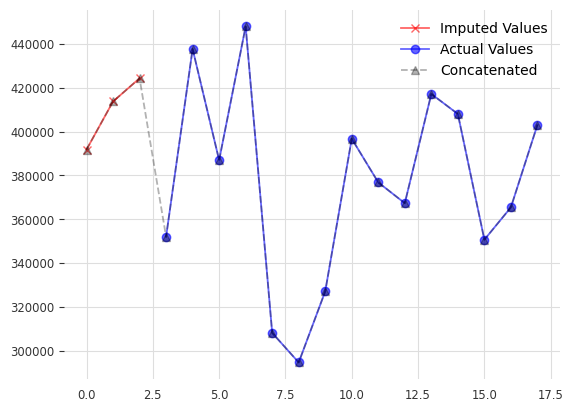

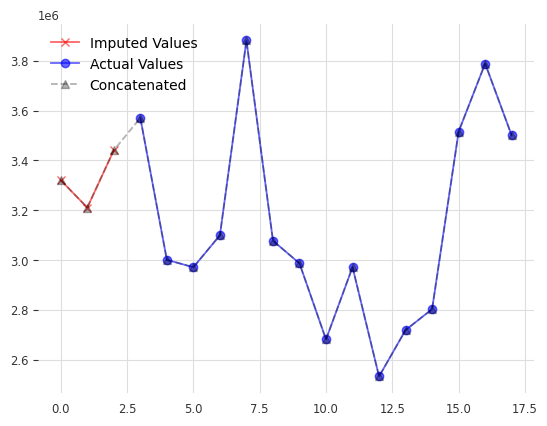

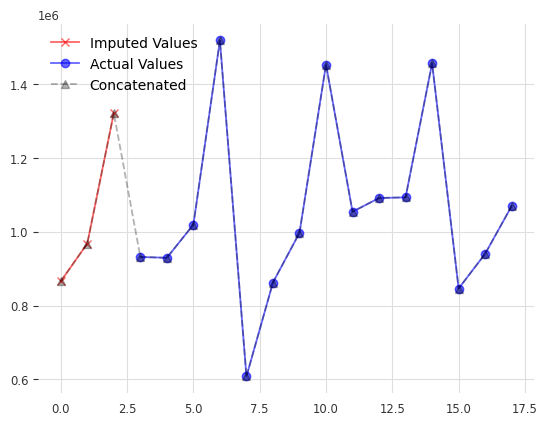

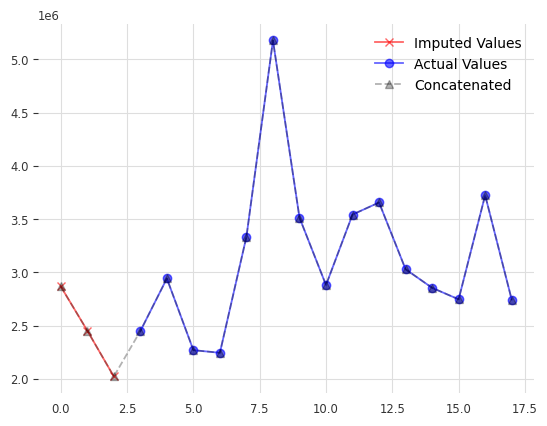

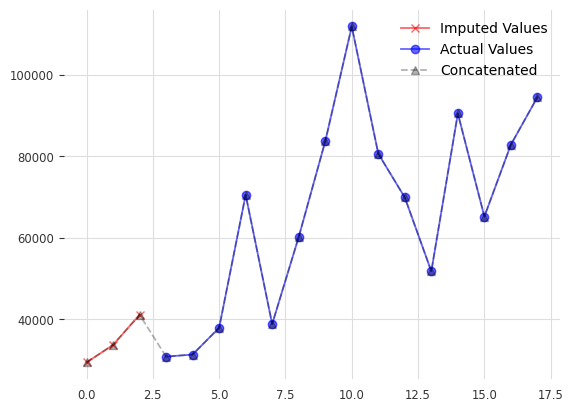

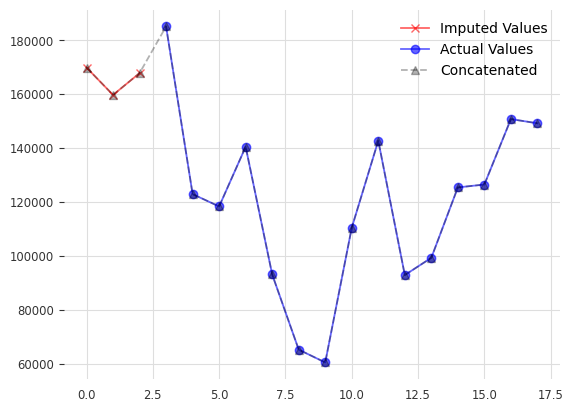

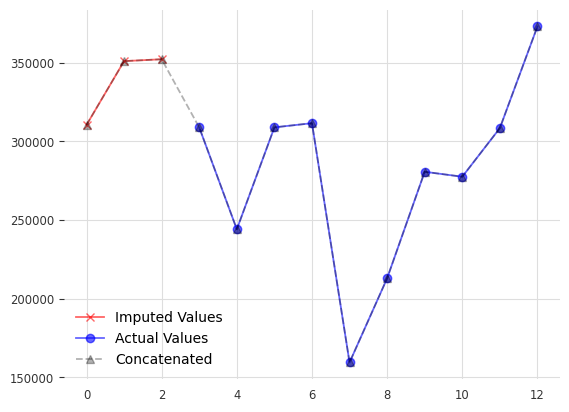

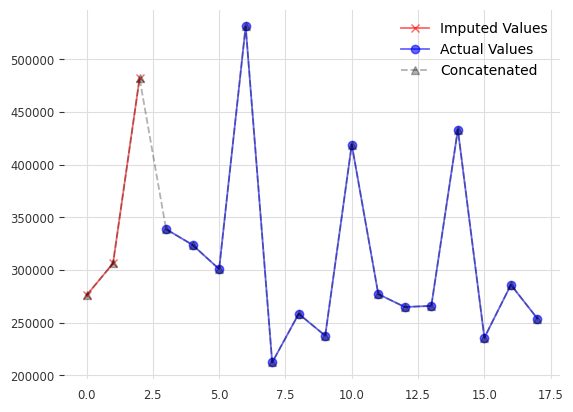

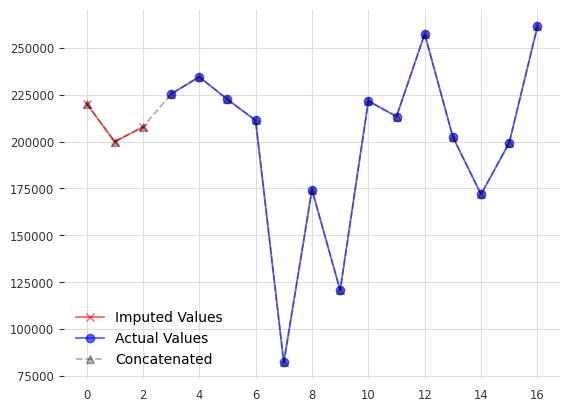

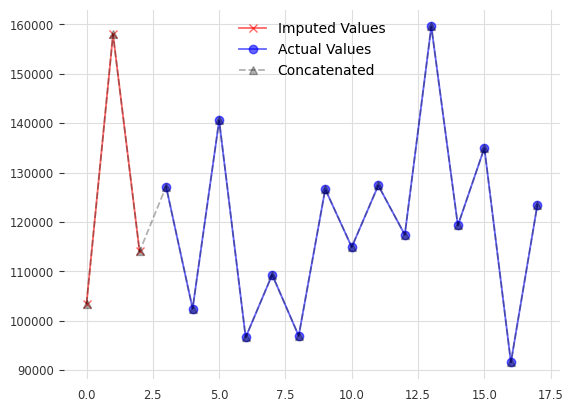

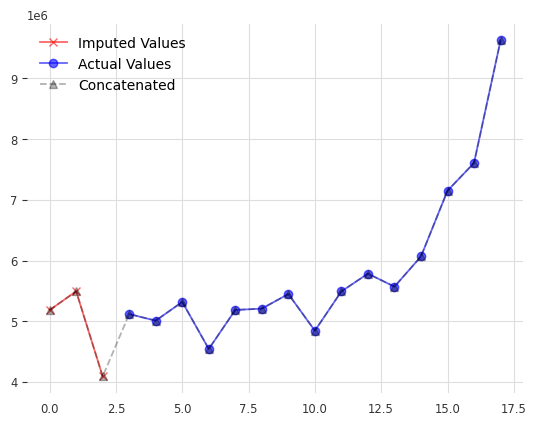

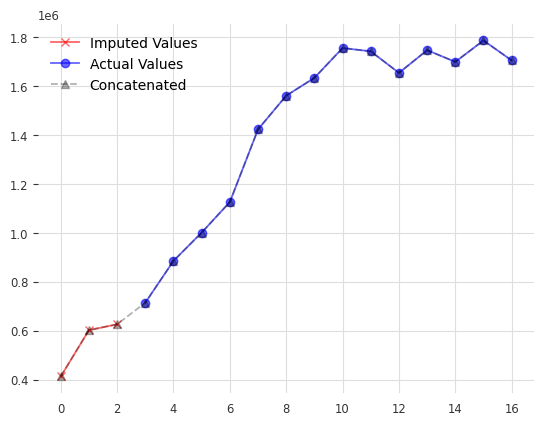

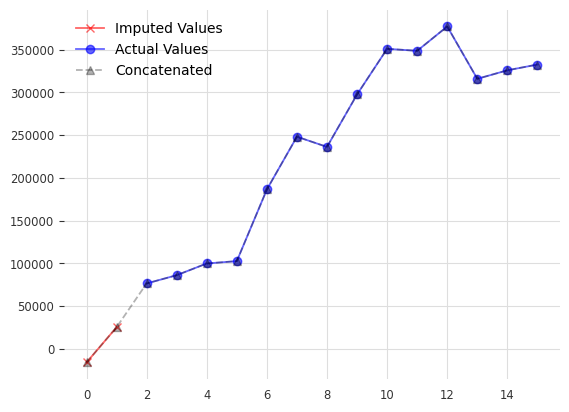

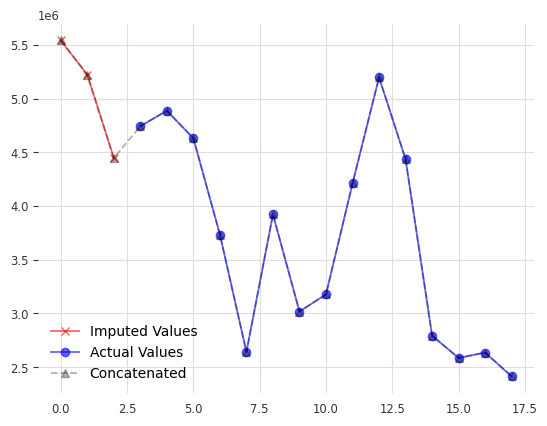

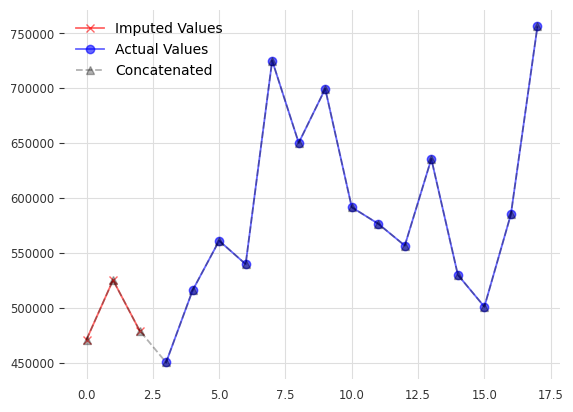

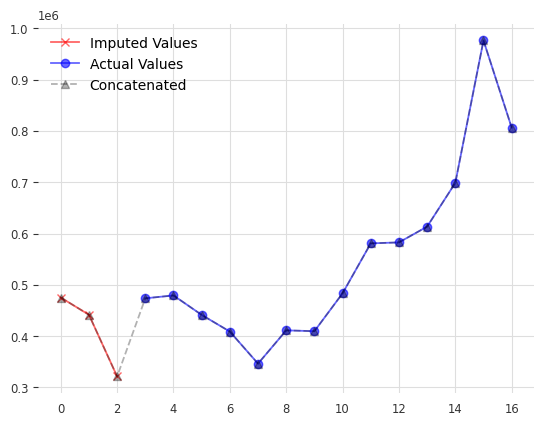

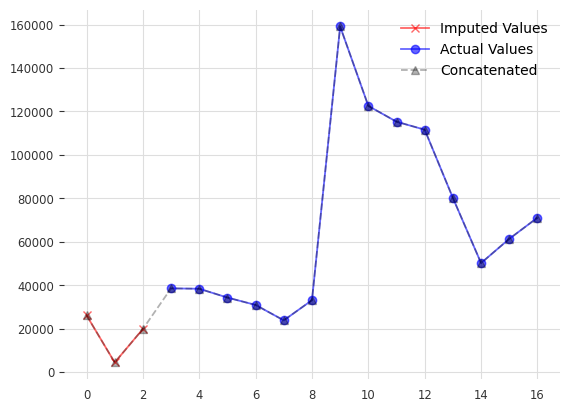

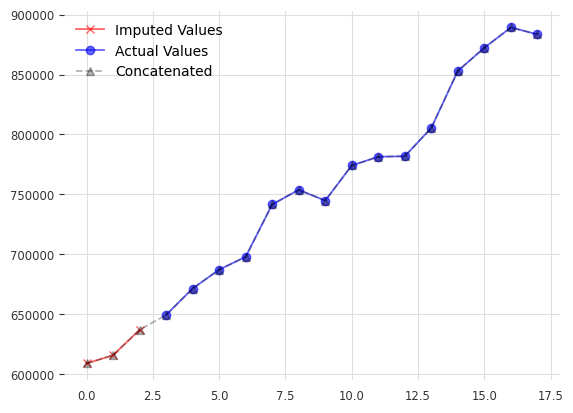

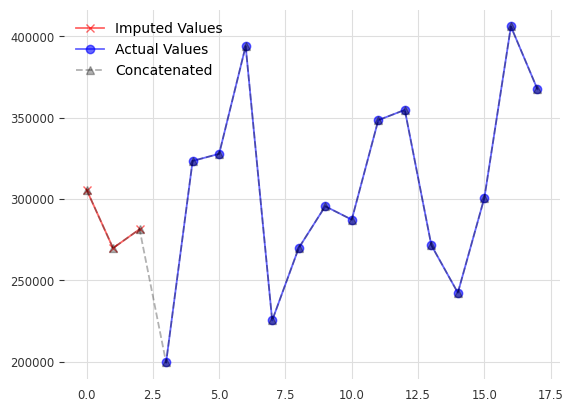

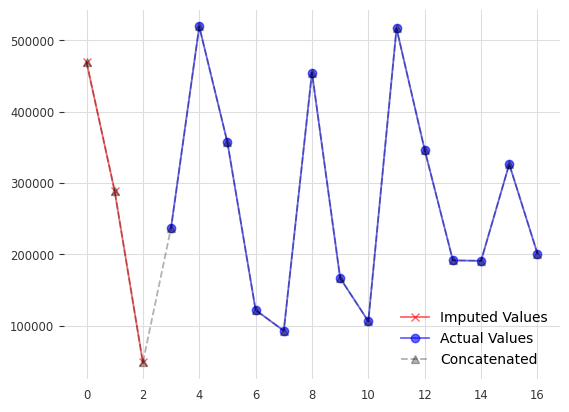

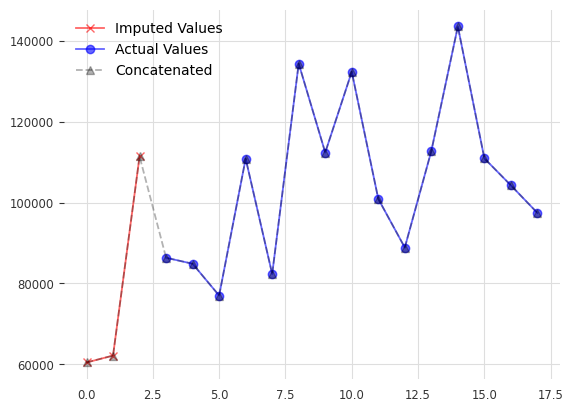

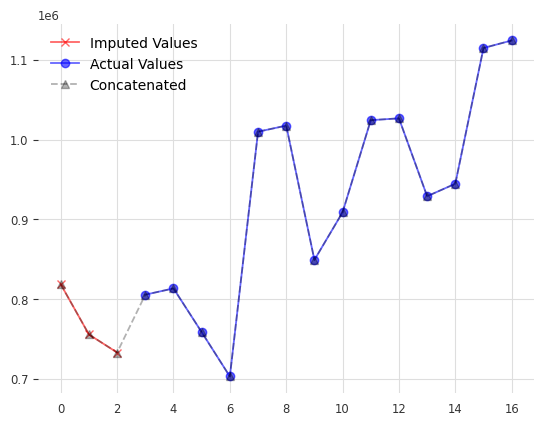

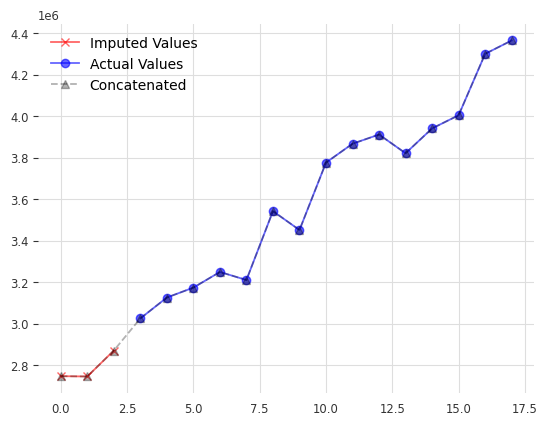

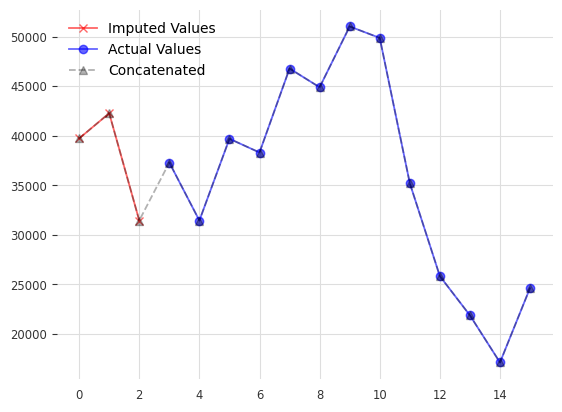

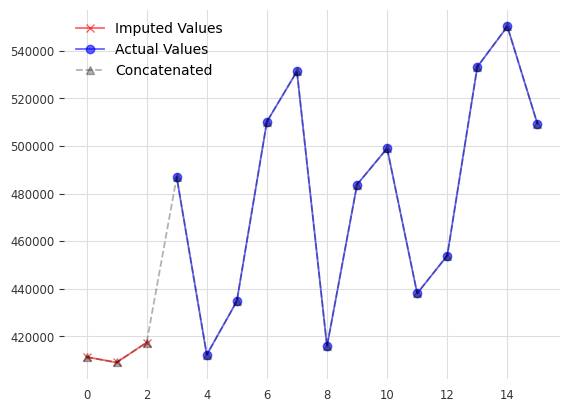

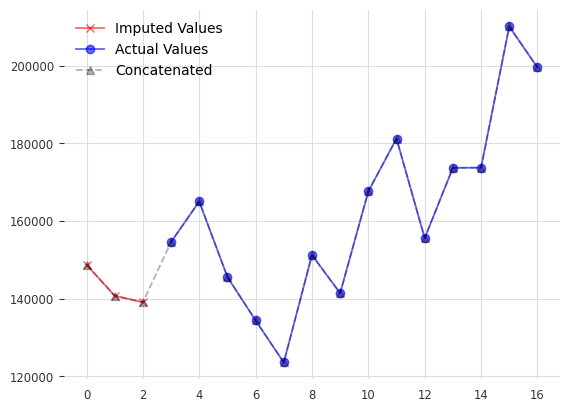

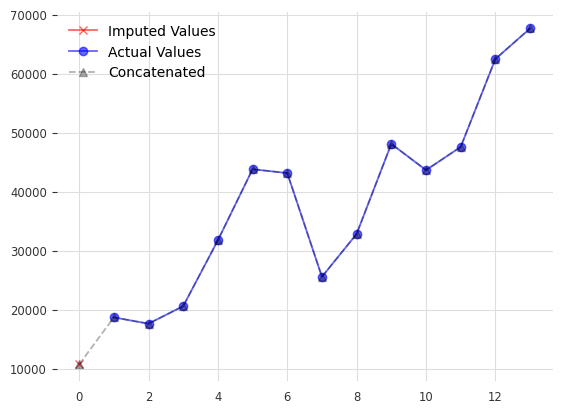

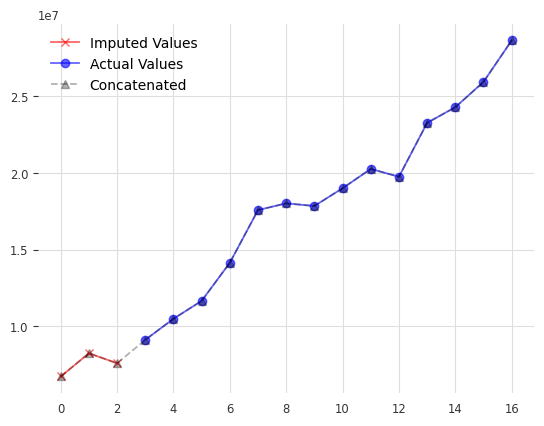

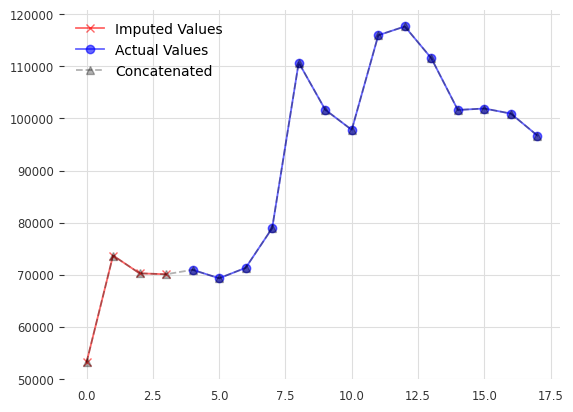

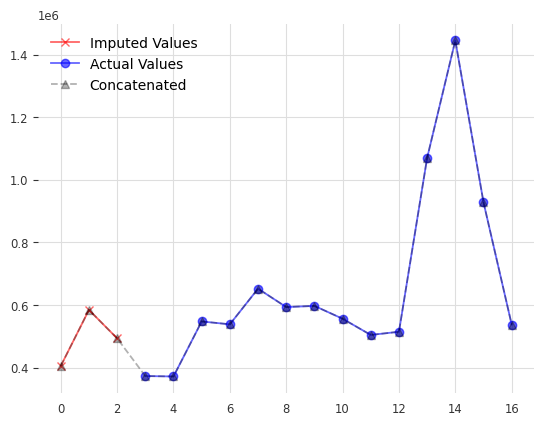

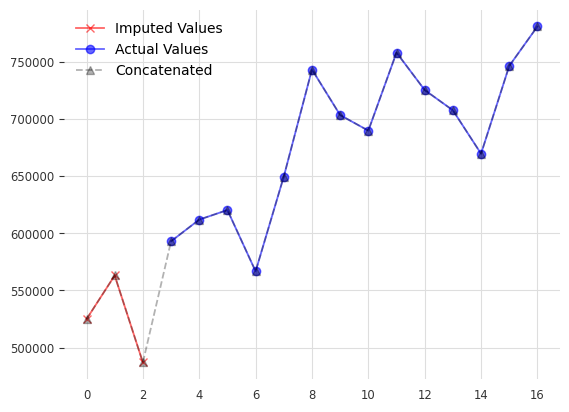

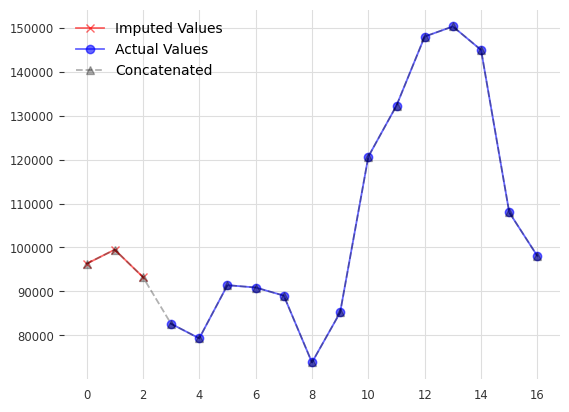

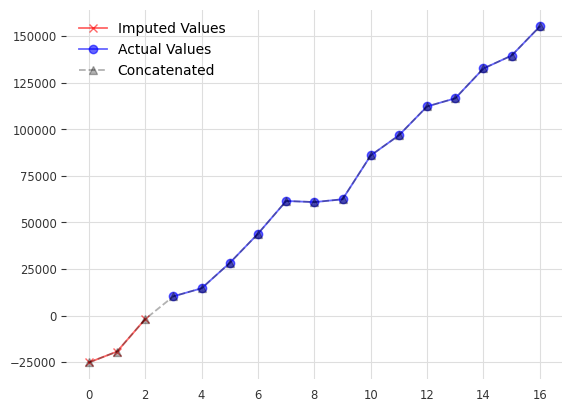

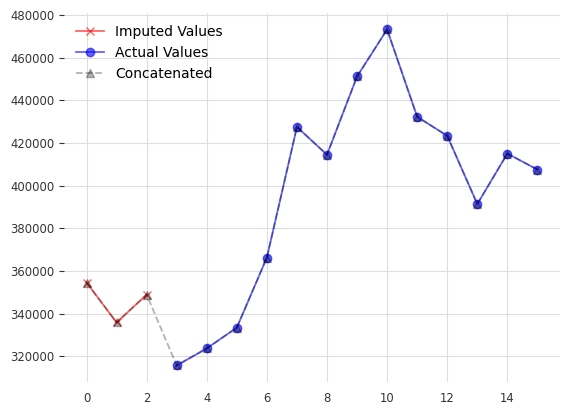

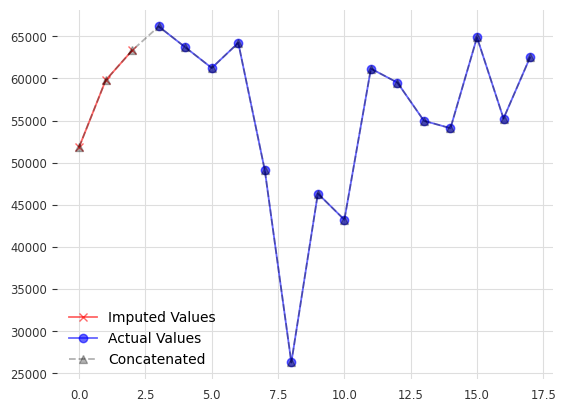

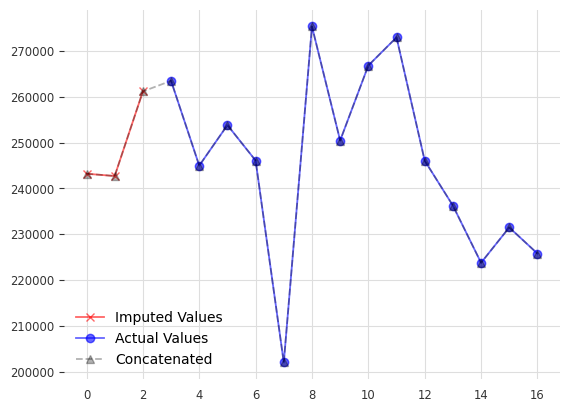

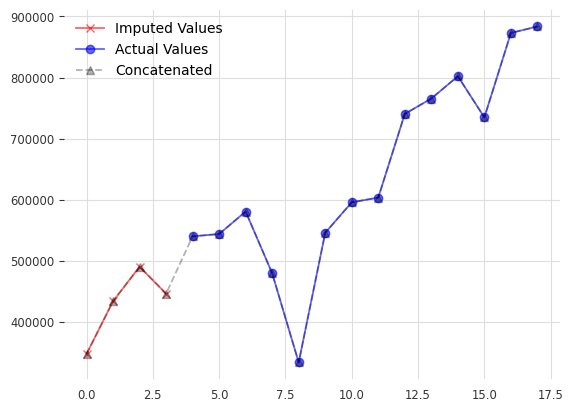

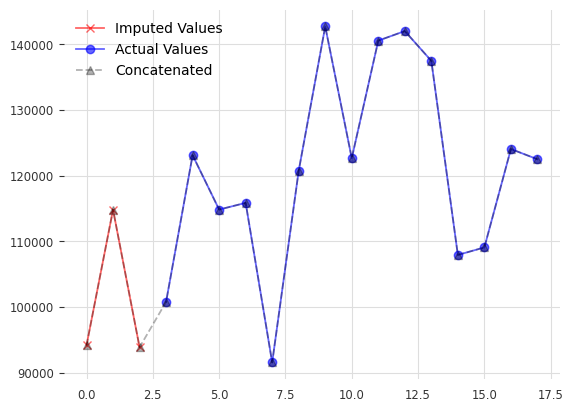

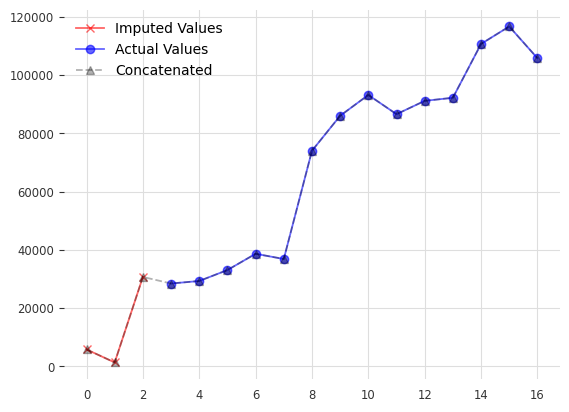

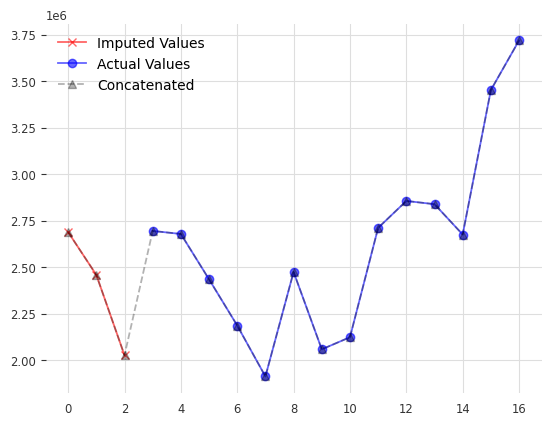

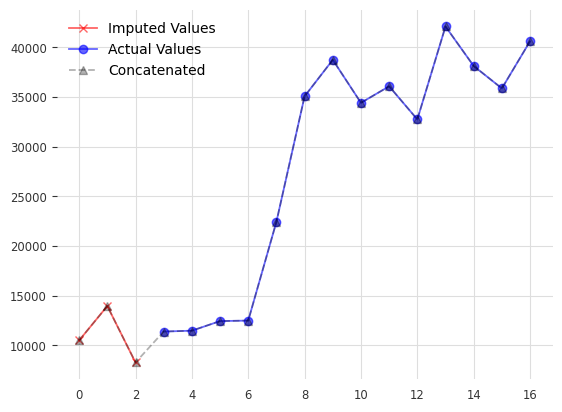

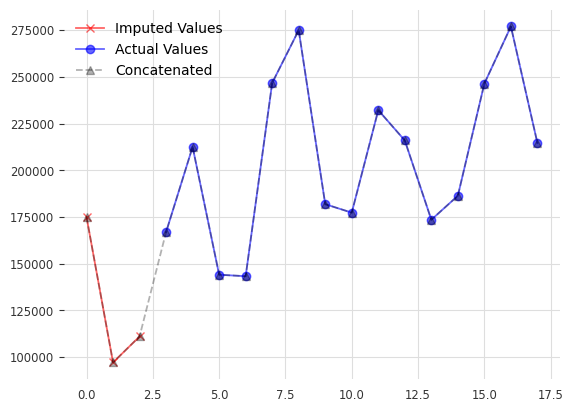

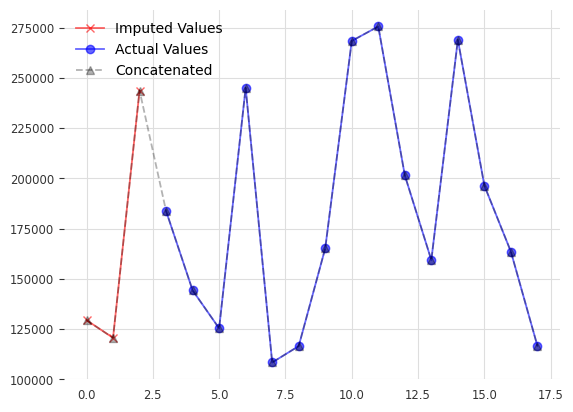

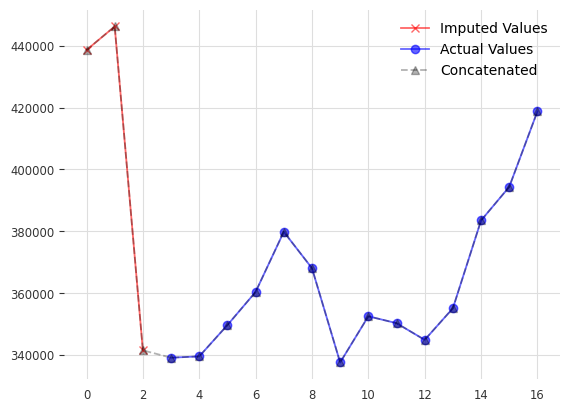

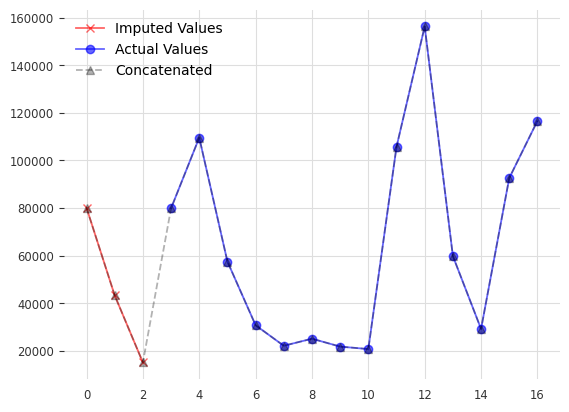

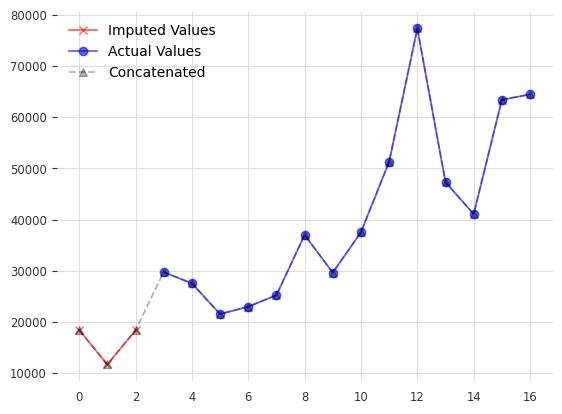

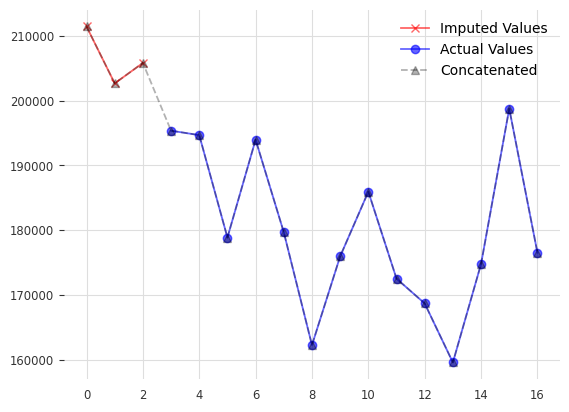

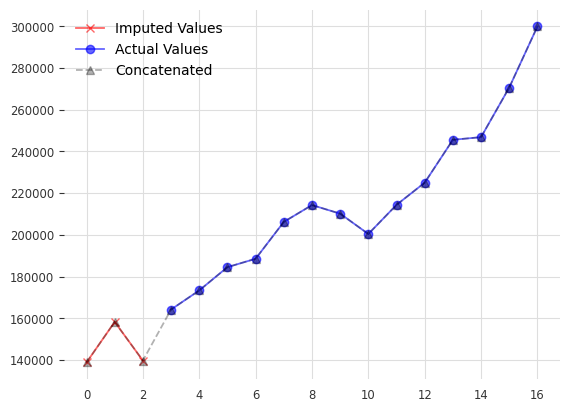

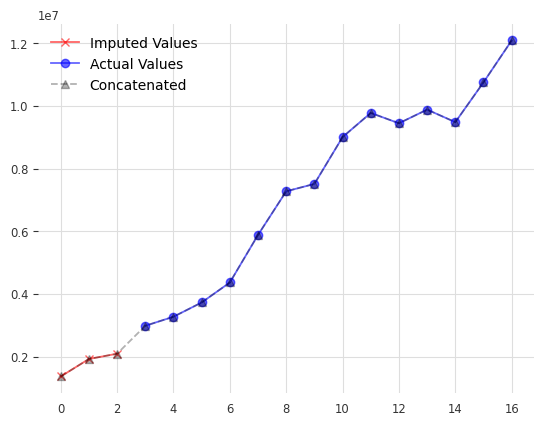

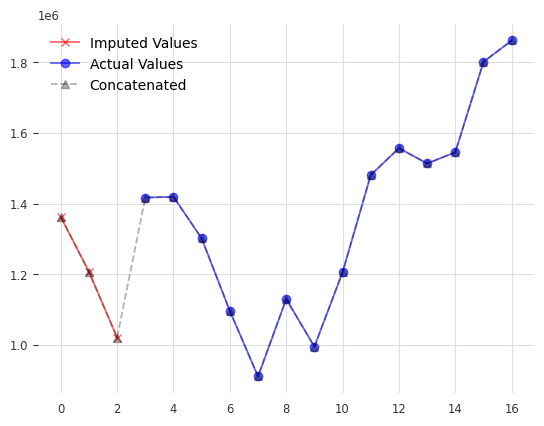

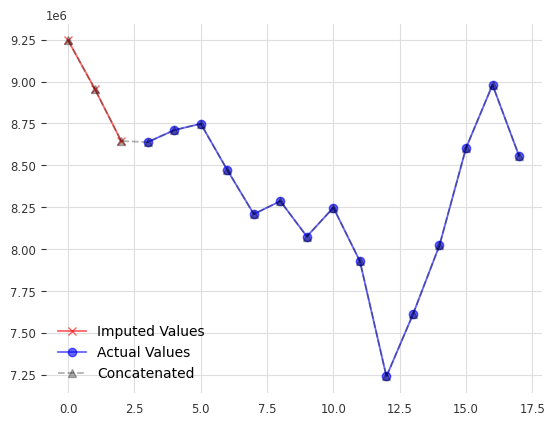

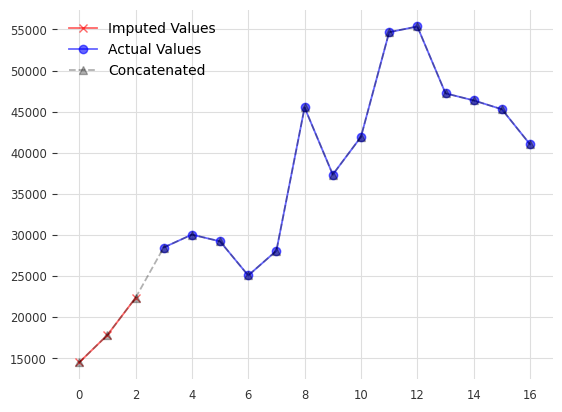

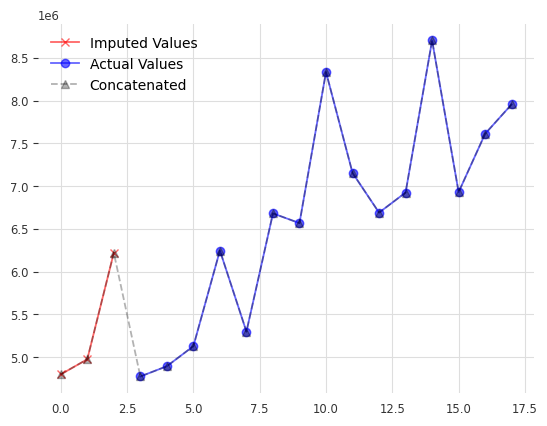

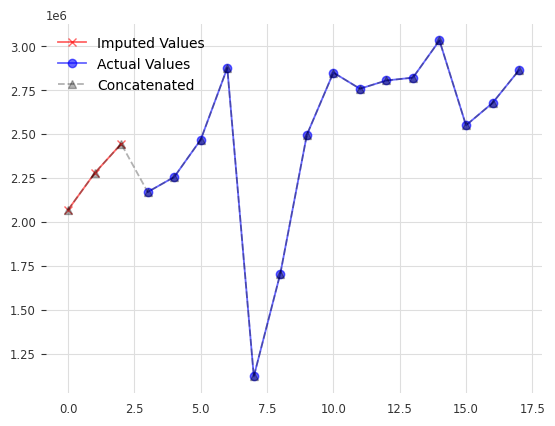

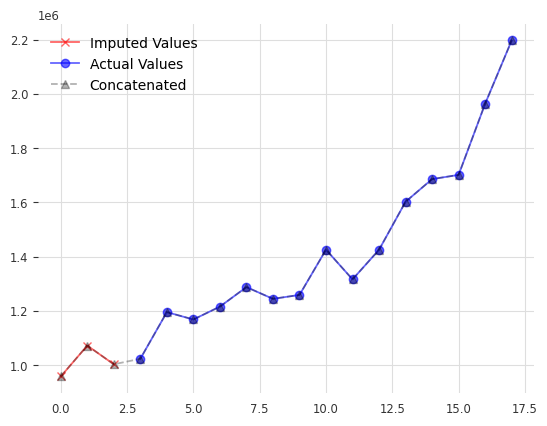

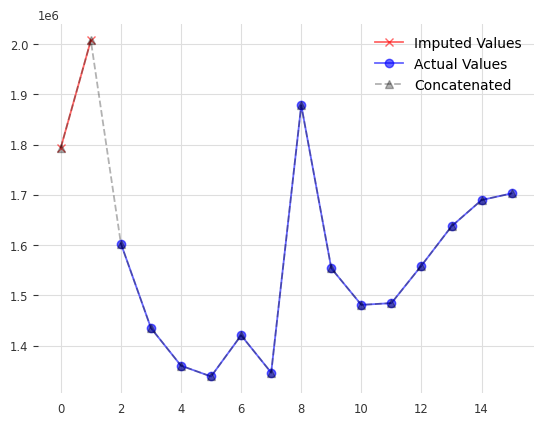

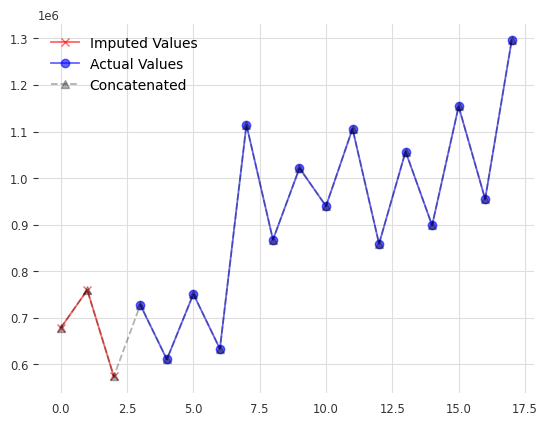

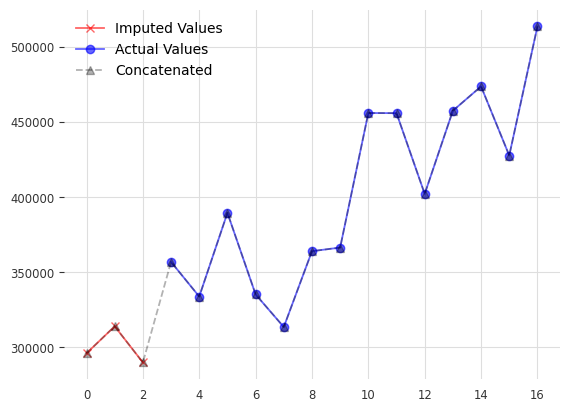

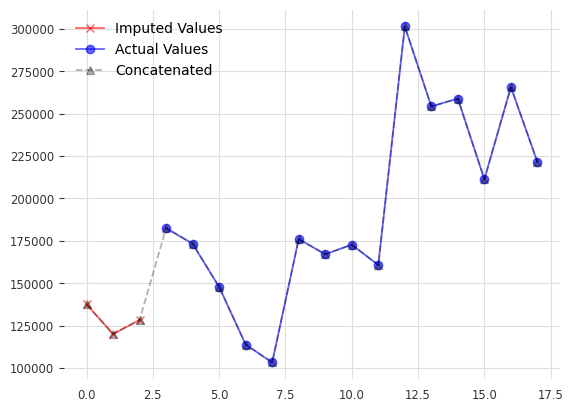

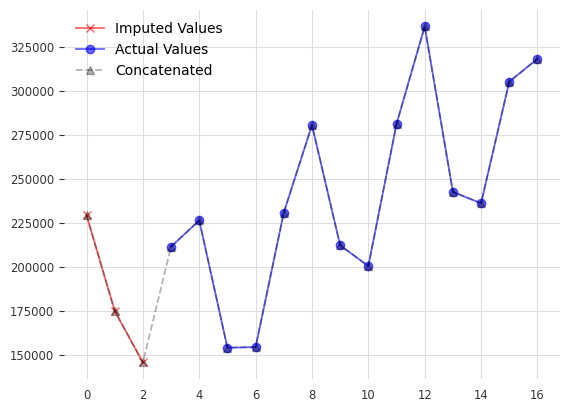

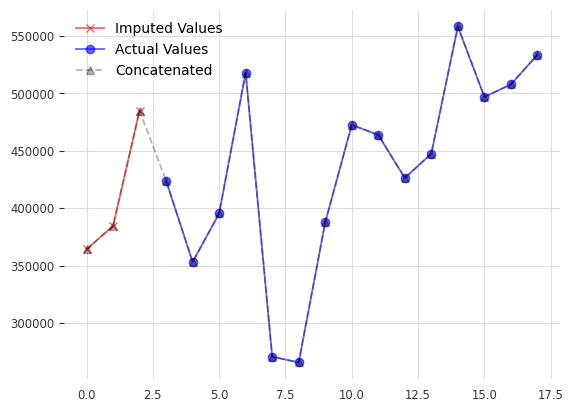

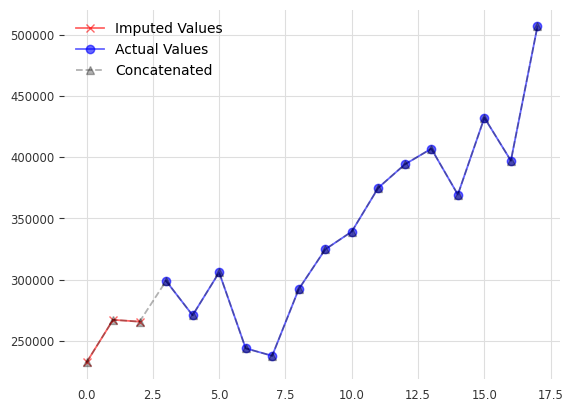

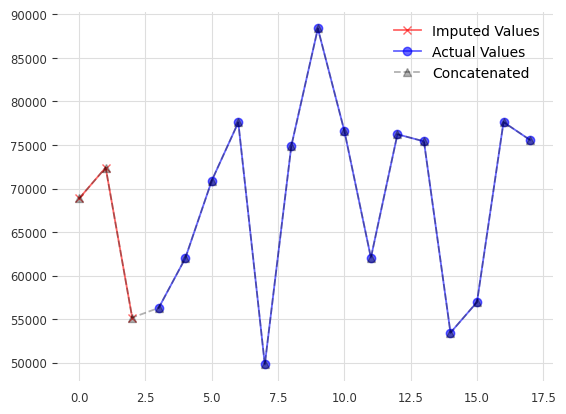

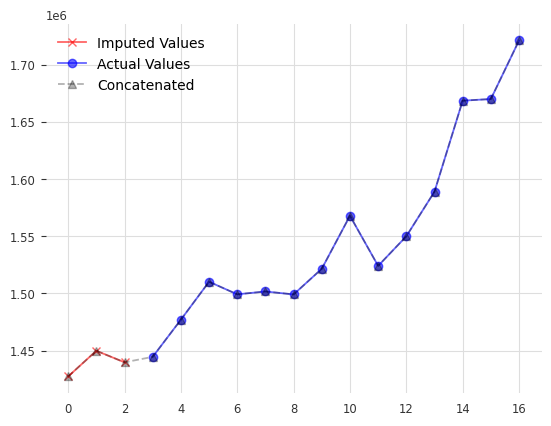

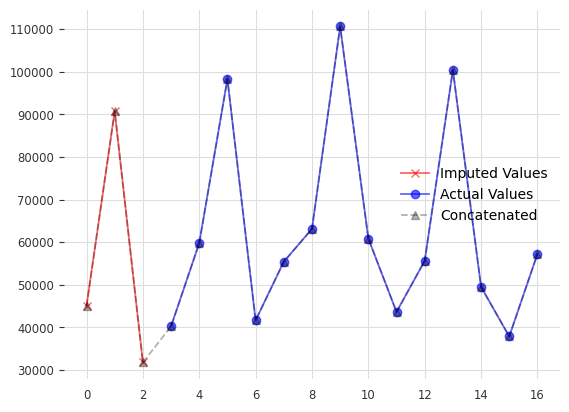

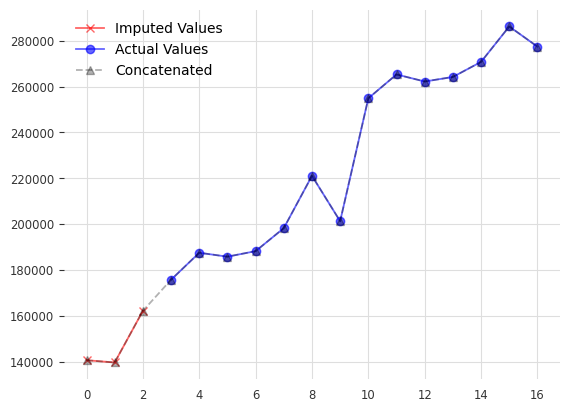

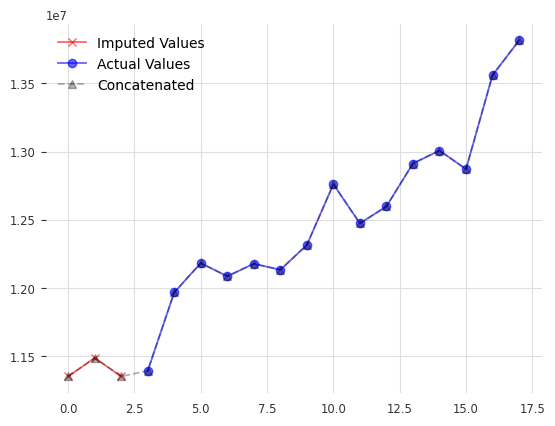

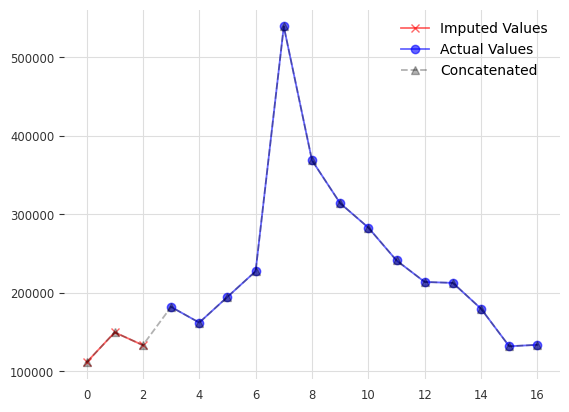

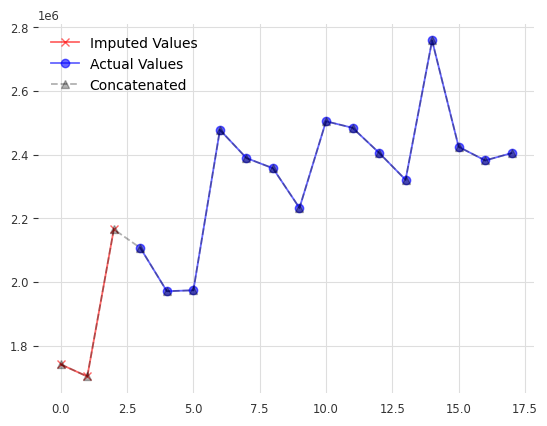

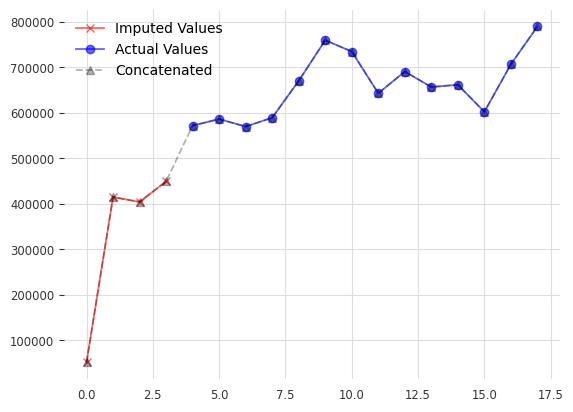

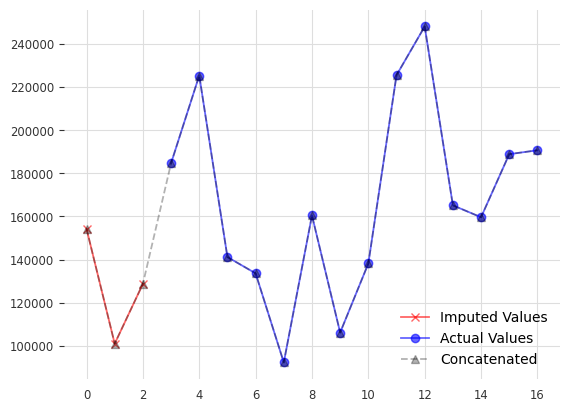

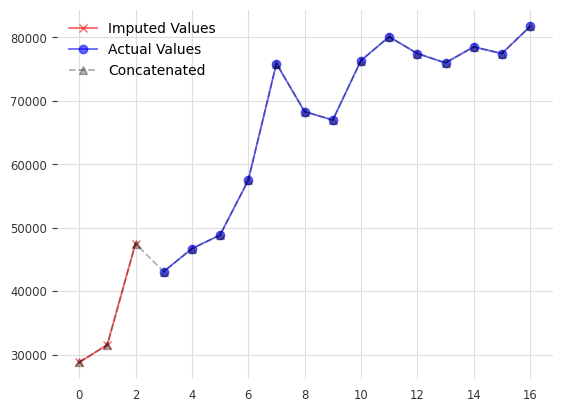

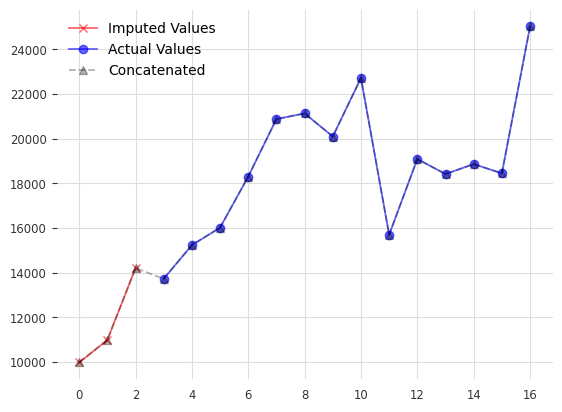

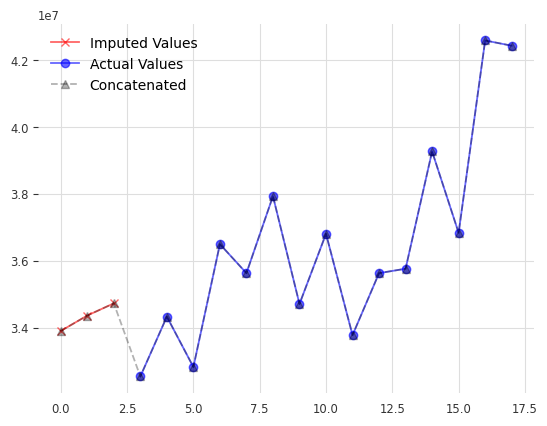

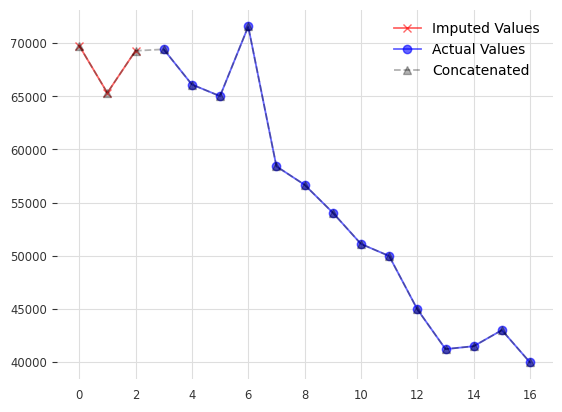

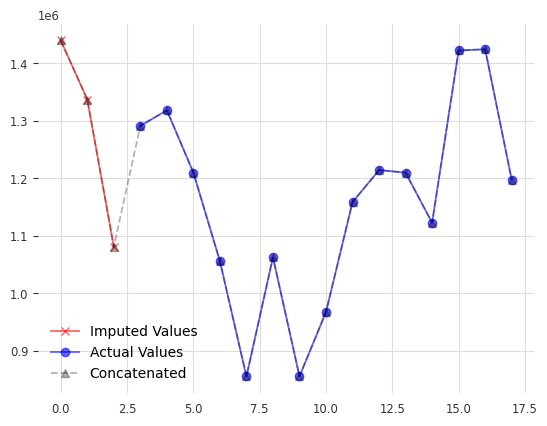

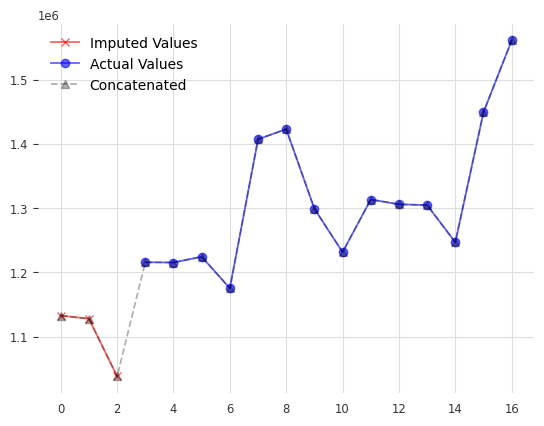

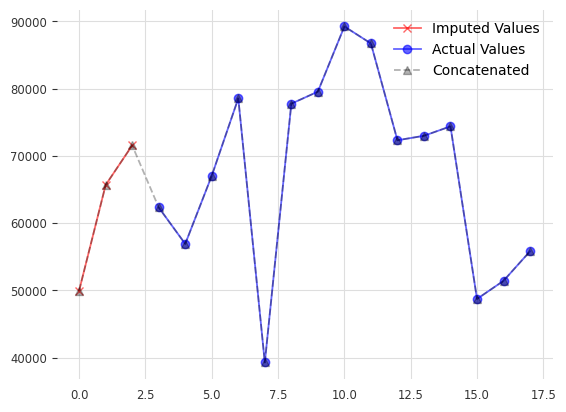

In [11]:
df = processor.impute_bankB_early_nans(df, plot=True)

Based on the plots a LLS solution looks sensible to the following time series, and thus handles many of the missing datapoints. The accuracy of these are however unknown. Bayesian regression can be performed to quantify uncertainty on the imputation on the missing values.

In [12]:
df.isna().sum()

mic                         0
ticker                      0
time                        0
nw_total_sales_a_total    154
nw_total_sales_b_total    205
Sales_Actual_fiscal        91
Sales_Estimate_fiscal     116
year                        0
month                       0
quarter                     0
is_war                      0
dtype: int64

### Now we can inspect if there are any more patterns in the NaNs that can be utilized to impute more of the missing data points

In [13]:
# getting data statistics
df.describe()

mic  nw_total_sales_a_total  nw_total_sales_b_total  \
count  3632.000000            3.478000e+03            3.427000e+03   
mean      3.515419            4.245079e+06            1.187036e+06   
std       0.715169            1.253527e+07            3.494607e+06   
min       0.000000            6.767840e+03           -2.521491e+04   
25%       3.000000            1.714414e+05            6.084657e+04   
50%       4.000000            6.723878e+05            1.985093e+05   
75%       4.000000            2.460207e+06            7.479082e+05   
max       7.000000            1.536824e+08            4.258561e+07   

       Sales_Actual_fiscal  Sales_Estimate_fiscal         year        month  \
count          3541.000000            3516.000000  3632.000000  3632.000000   
mean           9513.327372            9401.405726     2.210077     7.210077   
std           24737.725747           24385.675252     1.292598     3.363530   
min              19.143000              24.550000     0.000000     1.000000   
25%             580.900000             586.236387     1.000000     4.000000   
50%            1749.029000            1750.698200     2.000000     7.000000   
75%            5289.000000            5290.466550     3.000000    10.000000   
max          263187.000000          258562.440000     4.000000    12.000000   

           quarter       is_war  
count  3632.000000  3632.000000  
mean      2.582874     0.186399  
std       1.101694     0.389482  
min       1.000000     0.000000  
25%       2.000000     0.000000  
50%       3.000000     0.000000  
75%       4.000000     0.000000  
max       4.000000     1.000000

In [149]:
# Correlation Matrix
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

In [14]:
# inspecting remaning nans
print_nans_index(df)



Ticker: ABNB, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]
Column: Sales_Actual_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7]


Ticker: AEP, # Data points: 14
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


Ticker: AMC, # Data points: 16
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 7]


Ticker: BJRI, # Data points: 17
Column: nw_total_sales_a_total, NaN Indices: [7]
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 15]


Ticker: BKE, # Data points: 12
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Ticker: BOOT, # Data points: 11
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Ticker: CAR, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 6, 7, 9]


Ticker: CASY, # Data points: 17
Column: nw_total_sales_a_total, NaN Indices: [2]
Column: n

In [181]:
df_copy = df[df['ticker'] == 'ACI']
nan_copy = df_copy[df_copy['Sales_Actual_fiscal'].isna()].shape[0]
nan_copy

6

In [ ]:
def impute_sales_

Here the first 3 values were missing, and even though not necessarily they are 100% ground trouth wrt to the actual data, it makes intuitive sense with the rest of the series, and due to the strong linear dependency between terms, it is reasonable to assume that a least squares solution give approximate results. 

### The next step is to account for different regimes of NaNs
##### These are the cases I have considered:

1. either number of customers in bank A or number of customers in bank B are missing early, then apply LLS if no other values are missing

2. if only intermediary values are missing, we use a rolling average with respect to the column

3. if sales are missing either from estimate or actual, we can use one or the other with additive Gaussian noise to make predictions, as they have a very strong correlation 

4. if large amounts over a certain treshold is missing, we drop that column (or series), and do not use the preceding imputations of columns for those series


## Scaling Data
# TBD
Now, we have large discrepencies between the values for each column. Thus, it makes sense to normalize them and rather scale up after making predictions. 

### After Scaling
We can start by defining columns that can unveil underlying correlations. In doing so, we allow the network to find complex patterns within the data that otherwise would not have been unveiled

In [ ]:
def add_abs_difference(df):
    """ 
    
    """
    df['abs_diff_sales'] = np.abs(df['Sales_Actual_fiscal'] - df['Sales_Estimate_fiscal'])
    df['abs_diff_costumers'] = np.abs(df['nw_total_sales_a_total'] - df['nw_total_sales_b_total'])
    return df

def add_products(df):
    """ 
    
    """
    df['prod_sales'] = df['Sales_Actual_fiscal'] * df['Sales_Estimate_fiscal']
    df['prod_n_customers'] = df['nw_total_sales_a_total'] * df['nw_total_sales_b_total']
    return df

# Building Series from Darts

In [16]:
model = ModelPipeline(df)

In [17]:
series_dict = model.get_covs_target_dict()

In [18]:
df[df['ticker'] == 'LULU']

mic ticker       time  nw_total_sales_a_total  nw_total_sales_b_total  \
3991  3.0   LULU 2018-07-29                57414.19                     NaN   
3992  3.0   LULU 2018-10-28                63852.52                     NaN   
3993  3.0   LULU 2019-02-03               106998.02                     NaN   
3994  3.0   LULU 2019-05-05                60821.39                30807.16   
3995  3.0   LULU 2019-08-04                76463.52                31334.07   
3996  3.0   LULU 2019-11-03                83532.26                37889.27   
3997  3.0   LULU 2020-02-02               170870.52                70525.88   
3998  3.0   LULU 2020-05-03                91155.77                38798.29   
3999  3.0   LULU 2020-08-02               139472.10                60155.86   
4000  3.0   LULU 2020-11-01               178020.45                83626.30   
4001  3.0   LULU 2021-01-31               317219.50               111830.02   
4002  3.0   LULU 2021-05-02               191105.45                80610.44   
4003  3.0   LULU 2021-08-01               174569.46                69864.86   
4004  3.0   LULU 2021-10-31               122780.13                51745.63   
4005  3.0   LULU 2022-01-30               238875.84                90475.70   
4006  3.0   LULU 2022-05-01               222188.49                65185.76   
4007  3.0   LULU 2022-07-31               247761.91                82829.00   
4008  3.0   LULU 2022-10-30               266265.89                94487.46   

      Sales_Actual_fiscal  Sales_Estimate_fiscal  year  month  quarter  is_war  
3991              723.500              667.96400     0      7        3       0  
3992              747.655              737.52370     0     10        4       0  
3993             1167.450             1151.72440     1      2        1       0  
3994              782.315              756.11020     1      5        2       0  
3995              883.352              845.58980     1      8        3       0  
3996              916.138              899.27386     1     11        4       0  
3997             1397.491             1382.60900     2      2        1       0  
3998              651.962              691.62920     2      5        2       0  
3999              902.942              844.47534     2      8        3       0  
4000             1117.426             1015.96277     2     11        4       0  
4001             1729.550             1661.66690     3      1        1       0  
4002             1226.465             1127.63170     3      5        2       0  
4003             1450.618             1334.02050     3      8        3       0  
4004             1450.421             1431.66600     3     10        4       0  
4005             2129.113             2134.51170     4      1        1       0  
4006             1613.463             1546.17870     4      5        2       1  
4007             1868.328             1773.86010     4      7        3       1  
4008             1856.889             1814.29720     4     10        4       1

In [19]:
series_dict['LULU'][0]

<TimeSeries (DataArray) (time: 18, component: 7, sample: 1)>
array([[[5.74141900e+04],
        [           nan],
        [6.67964000e+02],
        [0.00000000e+00],
        [7.00000000e+00],
        [3.00000000e+00],
        [0.00000000e+00]],

       [[6.38525200e+04],
        [           nan],
        [7.37523700e+02],
        [0.00000000e+00],
        [1.00000000e+01],
        [4.00000000e+00],
        [0.00000000e+00]],

       [[1.06998020e+05],
        [           nan],
        [1.15172440e+03],
        [1.00000000e+00],
...
        [4.00000000e+00],
        [5.00000000e+00],
        [2.00000000e+00],
        [1.00000000e+00]],

       [[2.47761910e+05],
        [8.28290000e+04],
        [1.77386010e+03],
        [4.00000000e+00],
        [7.00000000e+00],
        [3.00000000e+00],
        [1.00000000e+00]],

       [[2.66265890e+05],
        [9.44874600e+04],
        [1.81429720e+03],
        [4.00000000e+00],
        [1.00000000e+01],
        [4.00000000e+00],
        [1.00000000e+00]]])
Coordinates:
  * time       (time) datetime64[ns] 2018-09-30 2018-12-31 ... 2022-12-31
  * component  (component) object 'nw_total_sales_a_total' ... 'is_war'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  2018-09-30  2018-12-31  2019-03-31...
    hierarchy:          None